Ce projet s'inscrit dans le cadre de la formation Data Scientist dispensée par Mines Paris PSL en partenariat avec DataScientest.com.

L’objectif est de classifier des images microscopiques de différents types de cellules sanguines à l’aide d'algorithmes de Computer Vision.

In [ ]:
# TODO : fonction pour afficher les résultats après éval finale (ML et DL)

# loss (balancé par class_weight ou sample weight)
# accuracy
# bal_accuracy
# confusion matrix et normalized cm (version display pandas et matplotlib)
# classification_report (version display du format dict)
# classification_report_imbalanced (voir si ça apporte qqch sinon virer imblearn)

# sauvegarde des 4 csv

"""
cm = pd.crosstab(y_res_test, y_res_pred)
    # Matrice de confusion normalisée
    cm_norm = cm.div(cm.sum(axis=1), axis=0)
    dict_report = classification_report(y_res_test, y_res_pred, output_dict=True)
    dict_report["balanced_accuracy"] = balanced_accuracy  # type: ignore
    dict_report["log_loss"] = loss  # type: ignore
    df_report = pd.DataFrame(dict_report).T

    if verbose:
        print("loss:", loss)
        print("accuracy:", accuracy)
        print("balanced accuracy:", balanced_accuracy)
        display(cm)
        display(df_report.round(3))

    # Sauvegarder csv

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    path = os.path.join(PATH_JOBLIB, f"rf_confusion_matrix_{timestamp}.csv")
    cm.to_csv(path)

    cm_norm.to_csv(
        os.path.join(PATH_JOBLIB, f"rf_confusion_matrix_normalized_{timestamp}.csv")
    )

    path = os.path.join(PATH_JOBLIB, f"rf_classification_report_{timestamp}.csv")
    df_report.to_csv(path)

    # Visualisation confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

"""


# Préambule

## Import des librairies

In [ ]:
from typing import Tuple, List, Dict, Optional, Union, TypeVar, Any
import time
from datetime import datetime
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # Masque info(1), warning(2), error(3) de tensorflow

from IPython.core.display import HTML
from IPython.display import display
import random
from collections import defaultdict, Counter
import inspect
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import squarify
import itertools
import joblib

# import cv2
from PIL import Image
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
from scipy.stats import randint
from scipy.ndimage import uniform_filter, gaussian_filter1d

# Machine Learning
from sklearn import ensemble
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    log_loss,
)
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input as rn_v2_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as dn_preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

pd.set_option(
    "future.no_silent_downcasting", True
)  # masque warning de pandas (future deprecation)


Num GPUs Available:  1


## Définition des paramètres

In [ ]:
# contrôler la verbosité
verbose = True

# Number of cores used
n_cores = os.cpu_count()

print("Total number of logical cores:", n_cores)
n_jobs = (
    n_cores * 3 // 4  # type: ignore
)  # default = n_cores//2 to use half of logical cores #type:ignore
# increase for higher performance (you can try n_cores*3//4 or more)
# decrease if kernel dies (you can try n_cores//4 or less)
# minimum is 1, maximum = -1 (all cores)

print(
    "Number of logical cores used for parallel processing:",
    n_cores if n_jobs == -1 else n_jobs,
)

# Random state
random_state = 42  # default = 42
# use any int or None for no seed

# contrôler le chargement et la sauvegarde des datasets
LOAD_RAW = True  # default = True
SAVE_RAW_SPLITTED = False  # default = False
SAVE_RES = False  # default = False
SAVE_SUB = False  # default = False
LOAD_RES = False  # default = False

SAMPLE_SIZE = 2500  # default = 2500 : sub-dataset used for debugging
PERF_ML = False  # default = True
TUNE_RF = False  # default = True
TUNE_XGB = False  # default = True
TUNE_LGBM = True  # default = True
TUNE_CAT = False  # default = True

CALIB_RF = False  # default = True
CALIB_XGB = False  # default = True
FINAL_EVAL = False  # default = True


# Taille des images après pre-process
img_height = 100  # les images d'origine étant presque carrées,
img_width = 100
# le format 100x100 offre en général un bon rapport performance/rapidité

target_size = (img_height, img_width)

# Ration Train / Valid / Test
VALID_SPLIT = 0.15
TEST_SPLIT = 0.15

TUNE_DS = "SAM"  # 'RES', 'BIN' or 'SAM' #default = RES

# Chemin d'accès aux images originales (brutes)
PATH_RAW = "/home/did/Windows/Downloads/raw"

PATH_TRAIN = "/home/did/Windows/Downloads/raw_splitted/train"
PATH_VALID = "/home/did/Windows/Downloads/raw_splitted/valid"
PATH_TEST = "/home/did/Windows/Downloads/raw_splitted/test"

# Stockage des images après resize, drop duplicates et split
PATH_RES = "/home/did/Windows/Downloads/resized"

# Stockage du sub dataset
PATH_SUB = "/home/did/Windows/Downloads/sub_resized"

# Stockage des images après Binarization
PATH_BIN = "/home/did/Windows/Downloads/binarized"

# Stockage des modèles (ou poids) entraînés
PATH_JOBLIB = "/home/did/Windows/Downloads/joblib"
os.makedirs(PATH_JOBLIB, exist_ok=True)

# Stockage des modèles (ou poids) entraînés
PATH_KERAS = "/home/did/Windows/Downloads/keras"
os.makedirs(PATH_KERAS, exist_ok=True)


Total number of logical cores: 16
Number of logical cores used for parallel processing: 12


## Définition des fonctions et Classes

In [ ]:
def data_viz(path: Optional[Union[str, Path]] = None, X=None, y=None) -> Dict[str, int]:
    """
    Affiche le nombre et la répartition des images par classe à partir d'un répertoire ou de deux tableaux (X et y).

    Fonction très rapide car elle parcourt les dossiers avec la libraire pathlib sans charger les images

    Parameters
    ----------
    path : str, optional
        Chemin vers le dossier contenant les sous-dossiers (classes).
    X : array-like, optional
        Données d'image (non utilisées, seulement requis pour cohérence avec y).
    y : array-like, optional
        Étiquettes associées aux données X.

    Returns
    -------
    Dict[str, int]
        Dictionnaire des classes et de leur nombre d'images.
    """

    start_time = time.perf_counter()

    if path is not None and X is not None and y is not None:
        raise ValueError("Can't have both path and (X and y)")

    # computing image class distribution
    if path is not None:
        path = Path(path)  # Conversion explicite de path en Path
        counts = {}
        for subdir in path.iterdir():
            if subdir.is_dir():
                counts[subdir.name] = len(list(subdir.glob("*")))
    elif X is not None and y is not None:
        counts = Counter(y)
    else:
        raise ValueError("Either path or both X and y must be provided")

    print(
        f"ℹ️ {sum(counts.values())} images found in {int((time.perf_counter()-start_time)*1000)}ms, belonging to",
        len(counts.keys()),
        "classes:",
        list(counts.keys()),
    )

    # création d'une fig 4 axs

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    counts = dict(sorted(counts.items()))  # tri alphabétique des clés
    labels = list(counts.keys())
    values = list(counts.values())
    colors = [prop["color"] for prop in plt.rcParams["axes.prop_cycle"]][: len(counts)]
    colors_map = (
        {}
    )  # pour conserver l'association classe / couleur pour les graphs avec un tri différent (par valeurs)
    for i, label in enumerate(counts.keys()):
        colors_map[label] = colors[i]

    # bar graph

    bars = axs[0, 0].bar(x=labels, height=values, color=colors)
    axs[0, 0].tick_params(axis="x", rotation=50)
    for tick in axs[0, 0].get_xticklabels():
        tick.set_ha("right")  # alignement à droite des labels tournés
    axs[0, 0].set_title("Image Class Distribution – Bar Chart")
    axs[0, 0].spines["top"].set_visible(False)
    axs[0, 0].spines["right"].set_visible(False)

    # Ajouter les pourcentages au-dessus de chaque barre
    total = sum(values)
    proportions = [100 * value / total for value in values]
    offset = 0.01 * max(
        values
    )  # léger offset pour que le % ne soit pas trop proche de la barre
    for bar, prop in zip(bars, proportions):
        height = bar.get_height() + offset
        axs[0, 0].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{prop:.1f} %",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # pie graph

    def pie_autopct(values):  # closure function
        total = sum(values)

        def my_autopct(pct):
            val = int(round(pct * total / 100.0))
            # return f'{pct:.1f}% ({val})'    # format pct% (val)
            return val  # format val

        return my_autopct

    axs[0, 1].pie(
        x=values,
        labels=labels,
        autopct=pie_autopct(values),
        pctdistance=0.7,
        labeldistance=1.2,
    )
    axs[0, 1].set_title("Image Class Distribution - Pie Chart")

    # bar graph horizontal et par ordre croissant

    counts_h = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    labels_h = list(counts_h.keys())
    values_h = list(counts_h.values())
    colors_h = [
        colors_map[label] for label in labels_h
    ]  # on utilise le mappage des couleurs pour conserver l'association classe/couleur

    bars_h = axs[1, 0].barh(y=labels_h, width=values_h, color=colors_h)
    axs[1, 0].set_title("Image Class Distribution – Barh Chart")
    axs[1, 0].spines["top"].set_visible(False)
    axs[1, 0].spines["right"].set_visible(False)

    # Ajouter les pourcentages (et valeurs) à droite de chaque barre
    total = sum(values_h)
    proportions_h = [100 * value / total for value in values_h]
    offset = max(values_h) * 0.01
    for bar, prop, val in zip(bars_h, proportions_h, values_h):
        width = bar.get_width()
        axs[1, 0].text(
            width + offset,  # un tout petit peu à droite de la barre
            bar.get_y() + bar.get_height() / 2,
            f"{prop:.1f} % ({val})",
            va="center",
            ha="left",
            fontsize=10,
        )

    # treemap

    squarify.plot(sizes=values, label=labels, color=colors, alpha=0.8, ax=axs[1, 1])
    axs[1, 1].set_title("Image Class Distribution - Treemap")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    # affichage du dictionnaire en HTML colorisé si l'environnement le supporte (IPython)
    if "get_ipython" in globals():
        print_colored_table(counts, colors_map)
    else:
        print("HTML table needs IPython to be printed")

    return counts


def print_colored_table(counts, colors_map) -> None:
    total = sum(counts.values())
    rows = []
    for label, value in counts.items():
        color = colors_map.get(label, "#000000")
        percent = 100 * value / total
        rows.append(
            f"<tr>"
            f"<td style='color:{color}; text-align:left; padding-right: 10px;'>{label}</td>"
            f"<td style='color:black; text-align:left; padding-right: 10px;'>{value}</td>"
            f"<td style='color:black; text-align:left;'>{percent:.1f} %</td>"
            f"</tr>"
        )

    # Ajout de la ligne total
    rows.append(
        f"<tr style='font-weight:bold;'>"
        f"<td style='text-align:left; padding-right: 10px;'>Total</td>"
        f"<td style='text-align:left; padding-right: 10px;'>{total}</td>"
        f"<td style='text-align:left;'>100.0 %</td>"
        f"</tr>"
    )

    html = f"""
    <table style="border-collapse: collapse; width: 300px; font-family: Arial, sans-serif;">
        <thead>
            <tr>
                <th style='text-align:left; border-bottom: 1px solid #ccc;'>Class</th>
                <th style='text-align:left; border-bottom: 1px solid #ccc;'>Count</th>
                <th style='text-align:left; border-bottom: 1px solid #ccc;'>%</th>
            </tr>
        </thead>
        <tbody>
            {''.join(rows)}
        </tbody>
    </table>
    """
    display(HTML(html))


In [ ]:
def generate_filenames(y: List[str]) -> List[str]:
    """
    Génère des noms d'images à partir d'une liste de labels,
    au format label_XXX.png avec un padding dynamique.
    Utilisé par save_images si la liste des noms d'images n'est pas fournie.
    """
    counts = Counter(y)
    max_count = max(counts.values(), default=1)
    padding = len(str(max_count))  # calcule le nombre de chiffres nécessaires

    dico = {}
    names = []
    for label in y:
        dico[label] = dico.get(label, 0) + 1
        names.append(f"{label}_{dico[label]:0{padding}}.png")  # 0-padding dynamique
    return names


In [ ]:
def save_images(
    output_dir: str,
    X: List[np.ndarray],
    y: List[str],
    names: List[str] | None = None,
    target_size: Tuple[int, int] | None = None,
    overwrite: bool = False,
    verbose=True,
) -> Dict[str, int]:
    """
    Save a list of images to disk, sorted into subfolders by their labels.
    Uses 1-bit per pixel encoding if the image is binary (0/1 or 0/255)

    Parameters:
        output_dir (str): Directory to save images.
        X (List[np.ndarray]): List of images, each as a numpy array of type uint8 or float,
                              with values between 0 and 255 or normalized between 0 and 1.
                              Supported formats are:
                                 - Grayscale images as 2D arrays (height x width)
                                 - Grayscale images as 3D arrays (height x width x 1)
                                 - RGB images as 3D arrays (height x width x 3 channels)
                                 - RGBA images as 3D arrays (height x width x 4 channels)
        y (List[str]): Corresponding labels (used to create subfolders).
        names (List[str], optional): List of filenames for saving the images.
                                     If None, filenames are auto-generated based on labels and a unique index,
                                     using the function `generate_filenames(y)`.
                                     This ensures each saved file has a distinct, descriptive name.
        target_size (tuple, optional): Resize images to this size (width, height) before saving.
        overwrite (bool): Whether to overwrite existing files.
        verbose (bool): Whether to print progress messages.

    Returns:
        dict: Summary of operation with keys:
        - "written": int, number of images saved.
        - "skipped": int, number of images skipped because file exists and overwrite=False.
        - "total": int, total number of images processed.
    """

    start_time = time.perf_counter()

    warnings_count = 0

    # Gestion des ValueError
    if names is not None and len(names) != len(X):
        raise ValueError("Les listes 'X' et 'names' doivent avoir la même longueur")
    if len(y) != len(X):
        raise ValueError("Les listes 'X' et 'y' doivent avoir la même longueur")

    # if any(img.min() < 0 for img in X):                           #on ne peut pas tester X.min()<0 car X n'est pas obligatoirement un array (cas d'un batch d'images de tailles différentes...)
    #    raise ValueError("Pixel values contain negatives.")       #test enlevé car très coûteux, l'erreur sera levé par PIL qu moment du pil_img = Image.fromarray((img ...

    # Création de la liste names si elle n'est pas fournie
    if names is None:
        names = generate_filenames(y)

    # Create subfolders by label
    for label in set(y):
        subfolder = os.path.join(output_dir, label)
        try:
            os.makedirs(subfolder, exist_ok=True)
        except OSError as e:
            raise RuntimeError(f"Impossible de créer le dossier '{subfolder}': {e}")

    # Sauvegarde des images
    total = len(X)
    for idx, (img, label) in enumerate(
        tqdm(zip(X, y), total=total, desc=f"Writing {total} images")
    ):
        filename = names[idx]
        image_path = os.path.join(output_dir, label, filename)

        if os.path.exists(image_path) and not overwrite:
            warnings_count += 1
            continue

        if img.ndim not in [2, 3]:
            raise ValueError(
                f"Invalid image at index {idx}"
                f"(label: '{label}', filename: '{filename}'):"
                f"expected 2D (grayscale) or 3D (RGB/RGBA), got shape {img.shape}"
            )

        # convert to uint8 between 0 and 255
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

        # evaluate binarity
        unique_vals = np.unique(img)
        is_binary = set(unique_vals).issubset({0, 255})

        # convert to PIL Image
        pil_img = Image.fromarray(img)

        # Resize if needed
        if target_size is not None:
            pil_img = pil_img.resize(target_size, resample=Image.BILINEAR)  # type: ignore

        if is_binary:  # Save binary image with 1-bit PNG
            base, _ = os.path.splitext(image_path)  # drop original extension
            image_path = base + ".png"  # use .png instead
            if (
                os.path.exists(image_path) and not overwrite
            ):  # existence test with new extension.png
                warnings_count += 1
                continue
            else:
                pil_img.convert("1").save(image_path)
        else:
            # Save non-binary image with PIL directly
            pil_img.save(
                image_path
            )  # existence test already passed at the beginning of loop

    if warnings_count > 0 and verbose:
        print(f"⚠️ {warnings_count} files already existed and were not overwritten.")

    if verbose:
        print(
            f"✅ {len(X) - warnings_count} images written in {int(time.perf_counter()-start_time)}s in {output_dir}\n"
        )

    return {
        "written": len(X) - warnings_count,
        "skipped": warnings_count,
        "total": len(X),
    }


In [ ]:
T = TypeVar("T")


def process_duplicates(
    X: List[T],
    y: List[str] | None = None,
    names: List[str] | None = None,
    drop_duplicates=False,
    verbose=True,
    plot_duplicates: bool = True,
) -> Tuple[List[T], List[str], List[str], List[Tuple[int, int]]]:
    """
    Detect duplicate images based on hash comparison and returns the filtered data along with the list of duplicate pairs.
    If drop_duplicates = True, remove the second occurrence of duplicate images.

    Returns:
        Tuple of filtered (X, y, names, duplicates), keeping only unique images.
        Logs duplicated image pairs, with a warning for inter-class duplicates.
    """

    if not verbose:
        plot_duplicates = False  # on désactive plot_duplicates si verbose = False

    start_time = time.perf_counter()

    # Création d'une classe unique si elle n'est pas fournie
    if y is None:
        y = ["unknown" for _ in X]

    # Création de la liste names si elle n'est pas fournie
    if names is None:
        names = generate_filenames(y)

    if not drop_duplicates:
        X = X.copy()
        y = y.copy()
        names = names.copy()

    seen_hashes = {}
    duplicates = []

    if drop_duplicates:
        desc = "🗑️ Removing duplicates"
    else:
        desc = "🔍 Detecting duplicates (no removal)"

    for i, img in enumerate(tqdm(X, desc=desc)):
        # convert to ndarray if not already (optionnel si déjà fait avant)
        img = np.array(img)
        h = hashlib.sha256(
            img.tobytes()
        ).hexdigest()  # Créé un hash unique pour chaque image qui permet de détecter les doublons bcp plus rapidement: complexité O(n) au lieu de O(n2)
        if h not in seen_hashes:  # si le hash de l'image i est nouveau
            seen_hashes[h] = i  # on mémorise son indice i
        else:
            first_idx = seen_hashes[h]  # first_idx = indice de l'image existante
            duplicates.append((first_idx, i))  # l'image i est un doublon de first_idx

    if verbose:
        if duplicates:
            print(
                f"\nℹ️ {len(duplicates)} duplicates detected in {int(time.perf_counter()-start_time)}s\n"
            )
            # affichage des doublons après la boucle
            for n, (first_idx, i) in enumerate(duplicates):
                print(
                    f"{n+1}. {y[first_idx]} {names[first_idx]} has a duplicate: {y[i]} {names[i]}"
                )
                if y[first_idx] != y[i]:
                    print(
                        f"\n\t❗ Duplicates across classes: {y[first_idx]} ≠ {y[i]}\n"
                    )
                if plot_duplicates:
                    plt.subplot(121)
                    plt.imshow(X[first_idx])
                    plt.title(y[first_idx] + "\n" + names[first_idx])
                    plt.axis(False)
                    plt.subplot(122)
                    plt.imshow(X[i])
                    plt.title(y[i] + "\n" + names[i])
                    plt.axis(False)
                    plt.show()
        else:
            print("\n✅ No duplicates found.")

    # Extraction des images uniques
    indices_to_keep = list(seen_hashes.values())
    X = [X[i] for i in indices_to_keep]
    y = [y[i] for i in indices_to_keep]
    names = [names[i] for i in indices_to_keep]

    if verbose:
        inter_class_duplicates = sum(1 for p, i in duplicates if y[p] != y[i])
        print(
            f"🔀 Duplicate summary: {len(duplicates)} total, {inter_class_duplicates} across classes.\n"
        )
        print("ℹ️", len(X), "unique images belonging to", len(set(y)), "classes.\n")

    return X, y, names, duplicates


In [ ]:
def load_images(
    path: Path | str,
    target_size: Optional[Tuple[int, int]] = None,
    drop_duplicates: bool = False,
    verbose: bool = True,
    plot_duplicates: bool = True,
) -> Tuple[List[np.ndarray], List[str], List[str]]:
    """
    Load images from subfolders in `path`.
    Returns lists of images (as numpy arrays), labels (folder names), and filenames.
    """
    start_time = time.perf_counter()

    X, y, names = [], [], []
    path = Path(path)

    # Load, convert to RGB, resize and convert to ndarray
    class_folders = [p for p in path.iterdir() if p.is_dir()]

    for class_path in tqdm(
        class_folders, desc=f"Loading images from {len(class_folders)} subfolders"
    ):
        class_name = class_path.name
        for file_path in class_path.iterdir():
            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")
                    if target_size is not None:
                        img = img.resize(target_size, resample=Image.BILINEAR)  # type: ignore
                    arr = np.array(img)

                    X.append(arr)
                    y.append(class_name)
                    names.append(file_path.name)
            except Exception as e:
                if verbose:
                    print(f"❌ Skipped {file_path}: {e}")

    if verbose:
        print(
            f"\nℹ️ {len(y)} images loaded in {int(time.perf_counter()-start_time)}s, belonging to {len(set(y))} classes.\n"
        )

    # detect or remove duplicates according to drop_duplicates parameter
    if drop_duplicates:
        X, y, names, duplicates = process_duplicates(
            X, y, names, drop_duplicates, verbose, plot_duplicates
        )
    else:
        process_duplicates(
            X, y, names, drop_duplicates, verbose, plot_duplicates
        )  # process_duplicates doesn't remove duplicates from X,y,names and they are not affected to X,y,names

    # compute shapes and counts per class
    shapes = defaultdict(set)
    for img, lbl in zip(X, y):
        shapes[lbl].add(img.shape)

    counts = Counter(y)
    nunique = len(set().union(*shapes.values()))

    if verbose:

        print("Class distribution:")
        for lbl, shape_set in sorted(shapes.items()):
            print(
                f"{lbl:<15} ➜ {counts[lbl]:>6} images, {len(shapes[lbl]):>2} shape(s): {sorted(shapes[lbl])}"
            )

        # Ligne récapitulative
        print(
            ("\n⚠️ " if nunique > 1 else "\n✅ ")
            + f"{'Total':<12} ➜ {len(y):>6} images, {nunique:>2} shape(s): {sorted(set().union(*shapes.values()))}"
        )

    return X, y, names


In [ ]:
def print_class_distribution(y: List[str], name: str = "Set") -> None:
    counts = Counter(y)
    total = sum(counts.values())
    # Trouver la longueur max des noms de classes pour l'alignement
    max_len = max(len(cls) for cls in counts)
    print(f"\n=== {name} ===\t{total} images\n")
    print(f"{'Classe':<{max_len}} {'Count':>7} {'%':>7}")
    print("-" * (max_len + 16))  # longueur totale approximative du titre

    for cls, count in sorted(counts.items()):
        print(f"{cls:<{max_len}} {count:7}  {count/total:6.2%}")


In [ ]:
def flatten_dataset(X):
    """Aplatie un ensemble d'images ou d'échantillons en 2D (n_samples, features).

    Paramètres
    ----------
    X : array-like de forme (n_samples, ...)
        Ensemble d'images ou de données multidimensionnelles.

    Retourne
    -------
    X_flat : ndarray de forme (n_samples, n_features)
        Données aplaties pour être utilisées dans des modèles de machine learning classiques.
    """
    X = np.asarray(X)
    return X.reshape(len(X), -1)


In [ ]:
"""
Les fonctions ci-dessous permettent de définir les seuils utilisés dans class ImagesBinarizer sans importer scikit-image
Pour plus de précision, importer les fonctions de scikit-image au lieu de définir les fonctions ci-dessous :
from skimage.filters import (
    threshold_otsu,
    threshold_niblack,
    threshold_sauvola,
    threshold_yen)
"""


def threshold_otsu(image, nbins=256):
    hist, bin_edges = np.histogram(image.ravel(), bins=nbins)
    hist = hist.astype(float)
    hist /= hist.sum()

    cumsum = np.cumsum(hist)
    cummean = np.cumsum(hist * np.arange(nbins))
    mean_total = cummean[-1]

    numerator = (mean_total * cumsum - cummean) ** 2
    denominator = cumsum * (1 - cumsum)
    with np.errstate(divide="ignore", invalid="ignore"):
        sigma_b_squared = numerator / denominator
        sigma_b_squared[denominator == 0] = 0

    idx = np.argmax(sigma_b_squared)
    return bin_edges[idx]


def threshold_yen(image, nbins=256):
    image = image.ravel()
    hist, bin_edges = np.histogram(image, bins=nbins, range=(0, 1))
    hist = hist.astype(np.float64)
    hist_norm = hist / hist.sum()

    p1_sq = np.cumsum(hist_norm**2)
    p2_sq = np.cumsum(hist_norm[::-1] ** 2)[::-1]

    with np.errstate(divide="ignore", invalid="ignore"):
        criterion = np.log(p1_sq[:-1] * p2_sq[1:])
    threshold_idx = np.argmax(criterion)

    t = (bin_edges[threshold_idx] + bin_edges[threshold_idx + 1]) / 2
    return t


def threshold_niblack(image, window_size=15, k=0.2):
    image = image.astype(float)
    mean = uniform_filter(image, window_size)
    mean_sq = uniform_filter(image**2, window_size)
    std = np.sqrt(mean_sq - mean**2)
    return mean + k * std


def threshold_sauvola(image, window_size=15, k=0.2, r=128):
    image = image.astype(float)
    mean = uniform_filter(image, window_size)
    mean_sq = uniform_filter(image**2, window_size)
    std = np.sqrt(mean_sq - mean**2)
    return mean * (1 + k * ((std / r) - 1))


In [ ]:
class ImagesBinarizer:
    """
    Binarizes image datasets using a fixed or computed threshold.

    Methods:
        fit(X):                     Compute global Otsu and Yen thresholds.
        transform(X):               Apply binarization using the selected threshold.
        fit_transform(X):           Fit then transform.
        ########################get_thresholds():           Returns Otsu, Niblack, Sauvola and Yen thresholds.
        plot_threshold_analysis(X): Plot intensity distribution with threshold lines.
        show_samples(X, n_samples): Plot random binarized images.
        to_grayscale(X):            Convert a batch of images into grayscale images.

    Supports RGB, grayscale (2D/3D), and flattened (1D) images.
    """

    def __init__(self, threshold: float | str = 0.5):
        """
        Parameters:
            threshold: str or float
                'otsu', 'yen', 'niblack', 'sauvola' or float value for fixed threshold.
        """

        self.threshold_param = threshold
        self.otsu_ = None
        self.yen_ = None
        self.threshold_ = None

    def to_grayscale(self, X) -> np.ndarray:
        """
        Convert a batch of images (RGB, grayscale 2D/3D, or flattened 1D)
        into grayscale images:
          - flattened 1D images if input images are flattened,
          - 2D grayscale images otherwise.
        """
        X = np.asarray(X)

        if X.ndim == 2:  # batch of flatten 1D images (n_samples, pixels)
            return X

        elif X.ndim == 3:
            if (
                X.shape[-1] == 1
            ):  # batch of flattened images with a trailing 1 channel dim (n_samples, pixels, 1)
                return X.squeeze(axis=-1)
            else:
                return X  # batch of 2D grayscale images (n_samples, H, W)

        elif X.ndim == 4:
            if (
                X.shape[-1] == 1
            ):  # batch of 3D grayscale images (n_samples, height, width, 1) → flatten last dim
                return X.squeeze(axis=-1)
            elif X.shape[-1] == 3:  # batch of RGB images, convert each to grayscale 2D
                gray_images = [
                    0.2989 * img[..., 0] + 0.5870 * img[..., 1] + 0.1140 * img[..., 2]
                    for img in X
                ]  # 0.2989 * R + 0.5870 * G + 0.1140 * B are the real Rec. 601 luminance weights used by skimage.color.rgb2gray()
                return np.array(
                    gray_images
                )  # human eyes are more sensitive to green, then to red, and finally to blue.
            else:
                raise ValueError(f"Unexpected image shape: {X.shape[-1]}")

        else:
            raise ValueError(f"Unexpected input array dimensions: {X.ndim}")

    def fit(self, X, y=None) -> "ImagesBinarizer":
        """
        Compute global Otsu and Yen thresholds for the training set
        and estimate global-equivalent Niblack and Sauvola thresholds
        by computing the median of local thresholds (ie median of pixel threshold) per images

        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened) with shape
                (n_samples, ...) and pixel values in [0,255] or [0,1].
            y: Ignored (scikit-learn convention)

        Returns:
            self : fitted ImagesBinarizer
        """

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(
                f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead."
            )

        if X.min() < 0:
            raise ValueError(
                "Pixel values contain negatives, please check data preprocessing."
            )

        if X.max() > 1:
            X = X / 255.0  # Normalize pixels to [0,1]

        X_gray = self.to_grayscale(X)  # 2D or 3D

        # Compute global Otsu and Yen thresholds
        gray_pixels = X_gray.ravel()
        self.otsu_ = threshold_otsu(gray_pixels)
        self.yen_ = threshold_yen(gray_pixels)

        print(f"Otsu threshold = {self.otsu_}")
        print(f"Yen threshold  = {self.yen_}")

        if self.threshold_param == "otsu":
            self.threshold_ = self.otsu_
        elif self.threshold_param == "yen":
            self.threshold_ = self.yen_
        else:
            self.threshold_ = (
                self.threshold_param
            )  # can be a global float or a local method name

        return self

    def transform(self, X) -> np.ndarray:
        """
        Binarize a batch of images using global (fixed or computed during fit float) or local (str) threshold.

        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened) with pixel values in [0, 255] or [0, 1].

        Returns:
            np.ndarray
                Binarized images with pixel values 0 or 1.
        """

        # Vérifie que fit a été exécuté avant transform
        if self.threshold_ is None:
            raise RuntimeError("You must fit the transformer before calling transform.")

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(
                f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead."
            )

        if X.min() < 0:
            raise ValueError("Pixel values contain negatives.")

        if (
            X.max() > 1
        ):  # normalise si besoin pour être compatible avec le seuil entre 0 et 1
            X = X / 255.0

        X_gray = self.to_grayscale(X)

        # Binarization selon le seuil en pixel 0 ou 1
        # self.threshold_ peut être soit un float (seuil global) soit un str (méthode adaptative)

        if isinstance(self.threshold_, str):  # seuil local
            X_bin = []
            for img in X_gray:
                if self.threshold_ == "niblack":
                    thresh_local = threshold_niblack(img)
                elif self.threshold_ == "sauvola":
                    thresh_local = threshold_sauvola(img)
                else:
                    raise ValueError(
                        f"Invalid local threshold method: {self.threshold_}"
                    )
                binary_img = img > thresh_local
                X_bin.append(binary_img)
            return np.array(X_bin)
        else:  # seuil global
            return (X_gray > self.threshold_).astype(np.uint8)

    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.

        Parameters:
            X : array-like
                Batch of images to binarize.
            y: Ignored (scikit-learn convention)

        Returns:
            np.ndarray
                Binarized images as uint8 arrays (0 or 1).
        """

        return self.fit(X, y).transform(X)

    '''
    def get_thresholds(self):
        """
        Return computed and parameter thresholds.

        Returns:
            dict
        """
        if self.threshold_ is None:
            raise RuntimeError(
                "You must fit the transformer before calling get_thresholds."
            )

        # if self.threshold_param == 'otsu' or self.threshold_param == 'yen':
        #    param_type = "global"
        #    param_value = self.threshold_
        # elif self.threshold_param == 'niblack' or self.threshold_param == 'sauvola':
        #    param_type = "local"
        #    param_value = self.threshold_param
        # else:
        #    param_type = "custom"
        #    param_value = self.threshold_
        #
        return {
            "otsu": self.otsu_,
            "yen": self.yen_,
            "param_value": self.threshold_param,
        }
    '''

    def plot_threshold_analysis(self, X):
        """
        Display grayscale histogram with global threshold lines and RGB curves if applicable.

        Parameters:
            X : array-like
                Batch of images (RGB, grayscale, or flattened).
        """

        if self.otsu_ is None or self.yen_ is None:
            raise RuntimeError(
                "You must fit the transformer before calling plot_threshold_analysis"
            )

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(
                f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead."
            )

        if X.min() < 0:
            raise ValueError("Pixel values contain negatives.")

        if X.max() > 1:
            X = (
                X / 255.0
            )  # normalise si besoin pour afficher des intensités entre 0 et 1

        if X.ndim == 4:
            plt.figure(figsize=(8, 4))

            for i in tqdm(range(3), desc="Computing RGB colorimetry"):
                channel_i_pixels = X[:, :, :, i].ravel()
                hist, bins = np.histogram(channel_i_pixels, bins=256, range=(0, 1))
                hist_smooth = gaussian_filter1d(hist, sigma=2)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                plt.plot(bin_centers, hist_smooth, color=["red", "green", "blue"][i])

            plt.title("Grayscale & RGB Distribution with Thresholds")

            plt.xlabel("Intensity")
            plt.ylabel("Pixel count")
            plt.tight_layout()
            # plt.show()

        # Compute global-equivalent of adaptative thresholds
        # niblack_thresholds = []
        # sauvola_thresholds = []
        # for img in tqdm(X_gray, desc = "Computing eq. thresholds"):
        #    niblack_map = threshold_niblack(img)
        #    sauvola_map = threshold_sauvola(img)
        #    niblack_thresholds.append(np.median(niblack_map))
        #    sauvola_thresholds.append(np.median(sauvola_map))
        # niblack_eq = np.median(niblack_thresholds)
        # sauvola_eq = np.median(sauvola_thresholds)

        X_gray = self.to_grayscale(X)

        # plt.figure(figsize=(8, 4))

        # histogram luminance
        gray_pixels = X_gray.ravel()
        plt.hist(gray_pixels, bins=256, color="gray", alpha=0.7)

        # If a custom threshold, show it too in red
        if isinstance(self.threshold_param, float):
            plt.axvline(
                self.threshold_param,
                color="purple",
                linestyle="--",
                label=f"Custom = {self.threshold_}",
            )

        # Computed threshold lines
        plt.axvline(
            self.otsu_,
            color="orange",
            linestyle=":",
            label=f"Otsu (from fit) = {self.otsu_:.3f}",
        )
        plt.axvline(
            self.yen_,
            color="brown",
            linestyle=":",
            label=f"Yen (from fit) = {self.yen_:.3f}",
        )
        # plt.axvline(self.niblack_eq_, color='yellow', linestyle='-.', label=f"Niblack eq. = {niblack_eq:.3f}")
        # plt.axvline(self.sauvola_eq_, color='pink', linestyle='-.', label=f"Sauvola eq. = {sauvola_eq:.3f}")

        plt.legend()
        # plt.suptitle("Note: Otsu, Yen, Niblack and Sauvola Thresholds are computed during fit", fontsize=10, color='dimgray')

        # plt.suptitle("Luminance Histogram")
        # plt.title("Note: Otsu and Yen thresholds correspond to the fit batch", fontsize=10, color='dimgray', loc='right')

        plt.xlabel("Intensity")
        plt.ylabel("Pixel count")
        plt.tight_layout()
        plt.show()

    def show_sample(self, X, y=None, names=None):

        if self.otsu_ is None:
            raise RuntimeError("You must fit the transformer before calling show")

        X = np.asarray(X)

        # Accept 2D, 3D or 4D datasets
        if X.ndim not in [2, 3, 4]:
            raise ValueError(
                f"Expected 2D, 3D or 4D array, got {X.ndim}D array instead."
            )

        # Choisis 1 image au hasard
        idx = np.random.randint(len(X))
        img = X[idx]

        if img.min() < 0:
            raise ValueError("Pixel values contain negatives.")

        if img.max() > 1:
            img = (
                img / 255.0
            )  # normalise si besoin pour afficher des intensités entre 0 et 1

        img_gray = self.to_grayscale((img,))[0]
        img_bin = self.transform((img,))[0]

        fig, axs = plt.subplots(4, 5, figsize=(15, 12))

        # original
        axs[0, 0].imshow(img)
        axs[0, 0].axis("off")
        title = f"#{idx}"
        if y is not None:
            title += f" ({y[idx]})"
        if names is not None:
            title += f"\n{names[idx]}"
        axs[0, 0].set_title(title)

        # grayscale
        axs[0, 1].imshow(img_gray, cmap="gray")
        axs[0, 1].axis("off")
        axs[0, 1].set_title("grayscale")

        # RGB
        for i in range(3):
            img_i = img[:, :, i]
            axs[0, i + 2].imshow(img_i, cmap=["Reds_r", "Greens_r", "Blues_r"][i])
            axs[0, i + 2].axis("off")
            axs[0, i + 2].set_title(f"{['R channel', 'G channel', 'B channel'][i]}")

        # custom
        axs[1, 0].imshow(img_bin, cmap="gray", vmin=0, vmax=1)
        axs[1, 0].axis("off")
        axs[1, 0].set_title(f"custom = {self.threshold_param}")

        threshold_origin = self.threshold_
        # computed

        self.threshold_ = self.otsu_
        img_bin = self.transform((img,))[0]
        axs[1, 1].imshow(img_bin, cmap="gray", vmin=0, vmax=1)
        axs[1, 1].axis("off")
        axs[1, 1].set_title(f"Otsu (from fit) = {self.threshold_:.3f}")

        self.threshold_ = self.yen_
        img_bin = self.transform((img,))[0]
        axs[1, 2].imshow(img_bin, cmap="gray", vmin=0, vmax=1)
        axs[1, 2].axis("off")
        axs[1, 2].set_title(f"Yen (from fit) = {self.threshold_:.3f}")

        niblack_thresh = threshold_niblack(img_gray)
        niblack_img = img_gray > niblack_thresh
        axs[1, 3].imshow(niblack_img, cmap="gray", vmin=0, vmax=1)
        axs[1, 3].axis("off")
        axs[1, 3].set_title("Niblack")

        sauvola_thresh = threshold_sauvola(img_gray)
        sauvola_img = img_gray > sauvola_thresh
        axs[1, 4].imshow(sauvola_img, cmap="gray", vmin=0, vmax=1)
        axs[1, 4].axis("off")
        axs[1, 4].set_title("Sauvola")

        # range
        for i in range(9):
            row = i // 5 + 2
            col = i % 5
            self.threshold_ = (i + 1) / 10
            img_bin = self.transform((img,))[0]
            axs[row, col].imshow(img_bin, cmap="gray", vmin=0, vmax=1)
            axs[row, col].axis("off")
            axs[row, col].set_title(f"threshold = {self.threshold_:.1f}")

        self.threshold_ = threshold_origin

        # threshold analysis
        pixels_gray = img_gray.ravel()
        axs[3, 4].hist(pixels_gray, bins=256, color="gray", alpha=0.7)
        axs[3, 4].axvline(
            self.otsu_,
            color="orange",
            linestyle=":",
            label=f"Otsu (fit) = {self.otsu_:.3f}",
        )
        axs[3, 4].axvline(
            self.yen_,
            color="brown",
            linestyle=":",
            label=f"Yen (fit) = {self.yen_:.3f}",
        )
        if isinstance(threshold_origin, float):
            axs[3, 4].axvline(
                threshold_origin,
                color="purple",
                linestyle="--",
                label=f"custom = {threshold_origin}",
            )
            axs[3, 4].legend()
        axs[3, 4].set_xlabel("Intensity")
        axs[3, 4].set_ylabel("Pixel count")
        for i in range(3):
            pixels_i = img[:, :, i].ravel()
            hist, bins = np.histogram(pixels_i, bins=256, range=(0, 1))
            hist_smooth = gaussian_filter1d(hist, sigma=2)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            axs[3, 4].plot(bin_centers, hist_smooth, color=["red", "green", "blue"][i])

        plt.tight_layout()
        plt.show()


In [ ]:
def evaluate_ML_global(
    models, datasets, balanced_weights: bool = False, verbose: bool = True
) -> pd.DataFrame:

    global_start_time = time.perf_counter()

    # paramètres pour tous les modèles : standardization et encoding (pour homogénéiser le fit et predict même si ce n'est pas idéal)
    scale = True  # Tree-base models doesn't need scaling (RF, XGB, CAT, LGB). NB: KNN may work better with normalization instead of standardization
    encode = True  # encoding is mandatory only for XGB

    global_perf = pd.DataFrame()

    for dataset in datasets:

        X_train, X_valid, y_train, y_valid, dataset_name = dataset

        if verbose:
            print("===", dataset_name, "===\n")

        # Flatten une seule fois pour chaque dataset puis flatten = False sur tous les appels suivant (pour gagner en perf)
        X_train_flat = np.asarray(X_train).reshape(len(X_train), -1)
        X_valid_flat = np.asarray(X_valid).reshape(len(X_valid), -1)
        flatten = False

        dataset_models = []
        dataset_accuracies = []
        dataset_bal_accuracies = []
        dataset_durations = []

        for model in models:

            start_time = time.perf_counter()
            accuracy, bal_accuracy = evaluate_ML_model(
                model,
                X_train_flat,
                X_valid_flat,
                y_train,
                y_valid,
                flatten,
                scale,
                encode,
                balanced_weights,
                verbose,
            )
            end_time = time.perf_counter()

            duration = round(end_time - start_time, 3)
            dataset_models.append(model.__class__.__name__)
            dataset_accuracies.append(accuracy)
            dataset_bal_accuracies.append(bal_accuracy)
            dataset_durations.append(duration)

        dataset_perf = pd.DataFrame(
            {
                "Model": dataset_models,
                "Accuracy": dataset_accuracies,
                "Balanced accuracy": dataset_bal_accuracies,
                "Duration (s)": dataset_durations,
            }
        ).set_index("Model")

        dataset_perf.columns = pd.MultiIndex.from_product(
            [[dataset_name], dataset_perf.columns]
        )

        if verbose:
            display(dataset_perf)

        # concatenate dataset_perf DataFrames
        global_perf = pd.concat([global_perf, dataset_perf], axis=1)

    # Add Row Mean
    global_perf.loc["📊 Average"] = global_perf.mean(numeric_only=True)  # type: ignore

    # Add Col Mean

    # Sélection des colonnes acc, bal_acc et durations
    cols_acc = global_perf.columns[::3]  # type: ignore
    cols_bal_acc = global_perf.columns[1::3]
    cols_dur = global_perf.columns[2::3]  # type: ignore

    # Calcul des moyennes par ligne
    mean_accuracy = global_perf[cols_acc].mean(axis=1)  # type: ignore
    mean_bal_accuracy = global_perf[cols_bal_acc].mean(axis=1)
    mean_duration = global_perf[cols_dur].mean(axis=1)  # type: ignore

    # Création des nouvelles colonnes sous forme de DataFrame avec MultiIndex colonnes
    new_cols = pd.DataFrame(
        {
            ("📊 Average", "Accuracy"): mean_accuracy,
            ("📊 Average", "Balanced accuracy"): mean_bal_accuracy,
            ("📊 Average", "Duration (s)"): mean_duration,
        },
        index=global_perf.index,
    )  # type: ignore

    # Concaténation à droite
    global_perf = pd.concat([global_perf, new_cols], axis=1)

    # Arrondi selon colonne accuracy ou duration
    for idx, col in enumerate(global_perf.columns):
        if idx % 3 in [0, 1]:
            global_perf[col] = global_perf[col].round(3)  # accuracy or bal_accuracy
        else:
            global_perf[col] = global_perf[col].round(0).astype("Int64")  # duration

    # Remplace les NaN par des ✖️
    global_perf = global_perf.astype(object).fillna("✖️").infer_objects(copy=False)  # type: ignore

    if verbose:
        print("=== GLOBAL ===\n")
        global_end_time = time.perf_counter()
        duration = int(global_end_time - global_start_time)
        print(
            f"{len(models)} models evaluated on {len(datasets)} datasets in {duration} s\n"
        )
        display(global_perf)

    return global_perf


def evaluate_ML_model(
    clf,
    X_train,
    X_valid,
    y_train,
    y_valid,
    flatten: bool = True,
    scale: bool = True,
    encode: bool = True,
    balanced_weights: bool = False,
    verbose: bool = True,
) -> Tuple[float, float]:
    """
    Evaluate a classical ML classifier (e.g., SVM, KNN, RandomForest, XGBoost).

    Not designed for deep learning models.

    Parameters
    ----------
    clf : sklearn-like classifier
        The model to train and evaluate.
    X_train, X_valid : array-like
        Input features (images), optionally flattened and scaled.
    y_train, y_valid : array-like
        Ground-truth labels.
    flatten : bool, default=True
        Reshapes X into 2D arrays if needed (n_samples, -1).
    scale : bool, default=True
        Applies StandardScaler to input features.
    encode : bool, default=True
        Encodes y_train using LabelEncoder. y_valid remains untouched.
    balanced_weights : bool, default=False
        If True and clf supports `sample_weight`, compute balanced sample weights during fitting.
    verbose : bool, default=True
        Displays model info, duration, accuracy, confusion matrix, and classification report.

    Note: balanced_weights only works if clf.fit accepts sample_weight.
    For example:
    - ✅ RandomForestClassifier, SVC, XGBClassifier, LGBMClassifier, CatBoostClassifier
    - ❌ KNeighborsClassifier does not support sample weights

    Returns
    -------
    tuple of float
    (accuracy, balanced_accuracy)
    Accuracy score and balanced accuracy score on the validation set.
    """

    if flatten:
        X_train_flat = np.asarray(X_train).reshape(len(X_train), -1)
        X_valid_flat = np.asarray(X_valid).reshape(len(X_valid), -1)
    else:
        X_train_flat = np.asarray(X_train)
        X_valid_flat = np.asarray(X_valid)

    if scale:
        scaler = StandardScaler()
        X_train_flat = scaler.fit_transform(X_train_flat)
        X_valid_flat = scaler.transform(X_valid_flat)
    # NB1 : tree-based (RandomForest, XGBoost…) n’ont pas besoin de scaling mais le scaling est inoffensif
    # NB2 : KNN peut fonctionner mieux avec une normalisation (MinMaxScaler) plutôt que standardisation...

    if encode:
        encoder = LabelEncoder()
        encoder.fit(np.concatenate([y_train, y_valid]))  # sécurise l'encodage
        y_train_enc = encoder.transform(y_train)
        y_valid_enc = encoder.transform(y_valid)
    else:
        y_train_enc = y_train.copy()
        y_valid_enc = y_valid.copy()
        # inutile mais peut éviter des effets de bord si la fonction évolue

    if verbose:
        print(clf)
        start_time = time.perf_counter()  # start timing prediction

    if balanced_weights and "sample_weight" in inspect.signature(clf.fit).parameters:
        # vérifie que le param balanced_weight        y_valid_decoded = encoder.inverse_transform(y_valid_enc)s = True + que le classifier accepte sample_weight dans son fit
        sample_weights = compute_sample_weight("balanced", y_train)
        clf.fit(X_train_flat, y_train_enc, sample_weight=sample_weights)
    else:
        clf.fit(X_train_flat, y_train_enc)

    y_pred_enc = clf.predict(X_valid_flat)

    accuracy = accuracy_score(y_valid_enc, y_pred_enc)
    balanced_accuracy = balanced_accuracy_score(y_valid_enc, y_pred_enc)

    if encode:
        y_pred = encoder.inverse_transform(y_pred_enc)  # type: ignore
    else:
        y_pred = y_pred_enc

    if verbose:
        print("accuracy:", accuracy)
        print("balanced accuracy:", balanced_accuracy)
        end_time = time.perf_counter()  # end timing
        predict_time = end_time - start_time  # type: ignore # durée en secondes
        print(f"duration: {predict_time:.3f} s\n")
        display(pd.crosstab(y_valid, y_pred))
        print(classification_report(y_valid, y_pred))

    return float(accuracy), float(balanced_accuracy)
    # convertit accuracy en float pour éviter une erreur de type entre Float et float...


In [ ]:
def print_CV_results(search_CV, duration: int | None = None):
    """
    Print summary results from a fitted cross-validation search object (e.g. GridSearchCV or RandomizedSearchCV).

    Parameters
    ----------
    search_CV : sklearn.model_selection.BaseSearchCV
        A fitted GridSearchCV or RandomizedSearchCV object.
    """
    results = search_CV.cv_results_
    n_candidates = len(results["params"])
    n_folds = search_CV.cv.get_n_splits()
    n_fits = n_candidates * n_folds
    best_index = search_CV.best_index_
    best_params = results["params"][best_index]
    best_score = results["mean_test_score"][best_index]
    mean_score = np.mean(results["mean_test_score"])
    std_score = np.std(results["mean_test_score"])

    print(
        f"📊 {search_CV.best_estimator_.__class__.__name__} fitted using {search_CV.__class__.__name__}"
        + (f" in {int(duration)}s" if duration is not None else "")
    )
    print(
        f"    {n_folds} folds for each of {n_candidates} candidates, totalling {n_fits} fits"
    )
    if duration is not None:
        print(f"\t• Mean duration per fit: {duration/n_fits:.1f}s")
    print("\t• Best params  :", best_params)
    print("\t• Best score   :", round(best_score, 4))
    print("\t• Mean score   :", round(mean_score, 4))
    print("\t• Std score    : ", round(std_score, 4))


 === Cellule désactivée car non utilisée ===

def random_zoom_in(img, zoom_min=0.7, zoom_max=0.95, random_state=None):
    """
    Apply random centered zoom-in augmentation to the input image.

    Parameters:
        img (np.ndarray): Input RGB image as a NumPy array.
        zoom_min (float): Minimum zoom factor (<1), controls max zoom-in intensity.
        zoom_max (float): Maximum zoom factor (<=1).
            If set to 1, there's a statistical risk the output image
            might be identical or very close to the original.
        random_state (int or np.random.Generator, optional): Seed or generator for reproducibility.

    Returns:
        np.ndarray: Augmented image of the same size as input.
    """
    rng = np.random.default_rng(random_state)

    h, w = img.shape[:2]
    zoom_factor = rng.uniform(zoom_min, zoom_max)
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    y1 = (h - new_h) // 2
    x1 = (w - new_w) // 2

    crop = img[y1 : y1 + new_h, x1 : x1 + new_w]
    zoomed = cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)
    return zoomed


def augment_image(img, zoom_min=0.7, zoom_max=0.95, random_state=None):
    """
    Apply data augmentation to the image using only transformations
    that preserve the original size and avoid introducing blank borders.

    Operations applied:
    - Random horizontal flip
    - Random vertical flip
    - Random centered zoom-in

    Parameters:
        img (np.ndarray): Input RGB image.
        zoom_min (float): Minimum zoom factor for zoom-in (<1).
        zoom_max (float): Maximum zoom factor (should be <1 to guarantee variation).
        random_state (int or np.random.Generator, optional): Seed or generator for reproducibility.

    Returns:
        np.ndarray: Augmented image of the same size as input.
    """
    assert (
        0 < zoom_min < zoom_max <= 1
    ), "zoom_min and zoom_max must satisfy 0 < zoom_min < zoom_max <= 1"

    rng = np.random.default_rng(random_state)

    # Random horizontal flip
    if rng.random() < 0.5:
        img = cv2.flip(img, 1)

    # Random vertical flip
    if rng.random() < 0.5:
        img = cv2.flip(img, 0)

    # Random zoom-in
    img = random_zoom_in(img, zoom_min, zoom_max, random_state=rng)

    return img

# Data Visualisation

ℹ️ 17222 images found in 204ms, belonging to 9 classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphoblast', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


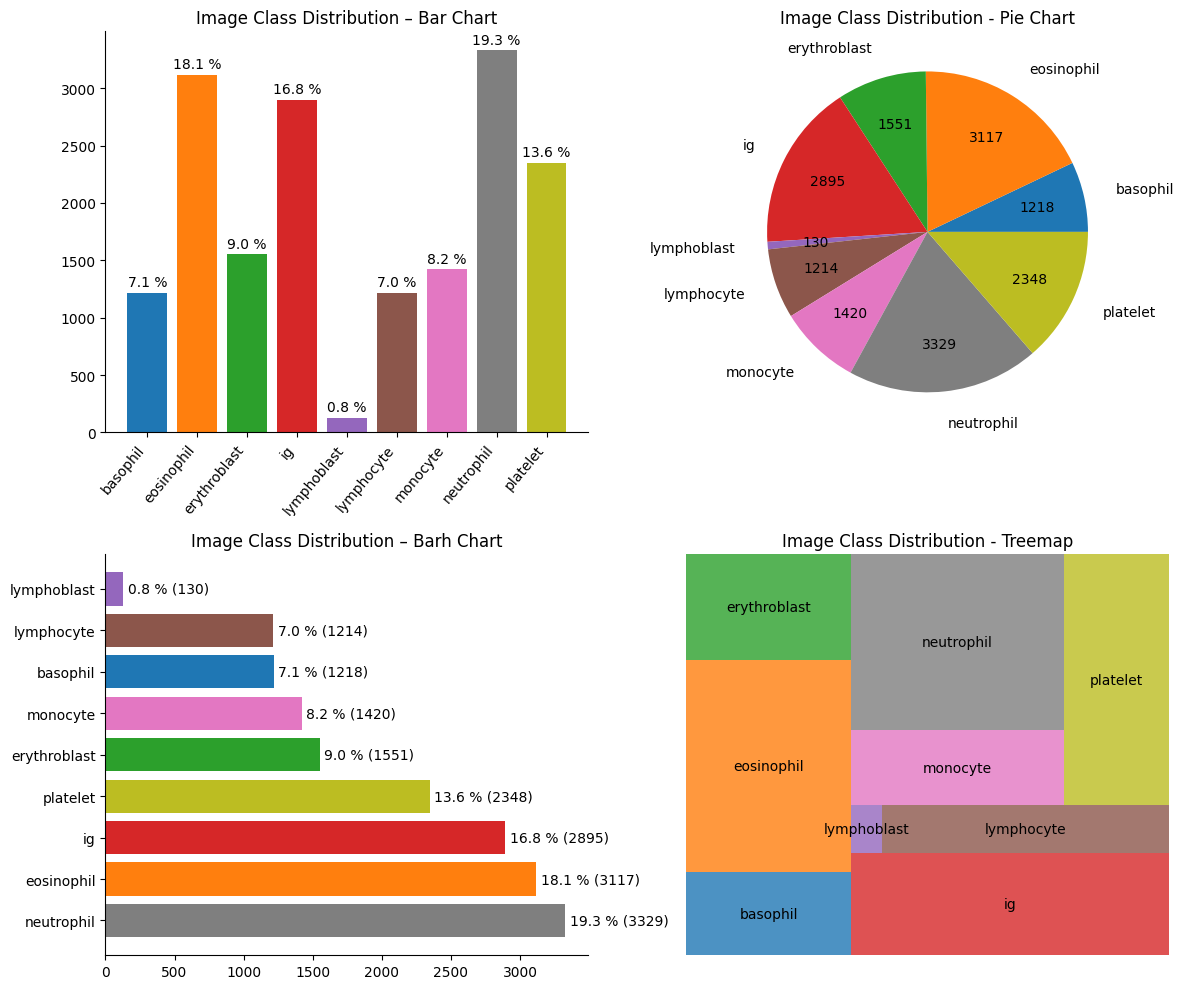

Class,Count,%
basophil,1218,7.1 %
eosinophil,3117,18.1 %
erythroblast,1551,9.0 %
ig,2895,16.8 %
lymphoblast,130,0.8 %
lymphocyte,1214,7.0 %
monocyte,1420,8.2 %
neutrophil,3329,19.3 %
platelet,2348,13.6 %
Total,17222,100.0 %


{'basophil': 1218,
 'eosinophil': 3117,
 'erythroblast': 1551,
 'ig': 2895,
 'lymphoblast': 130,
 'lymphocyte': 1214,
 'monocyte': 1420,
 'neutrophil': 3329,
 'platelet': 2348}

In [ ]:
data_viz(path=PATH_RAW)


# Pre-Processing

In [ ]:
# Load raw images without duplicates
if not LOAD_RAW:
    X, y, names = load_images(
        PATH_RAW,
        target_size=None,
        drop_duplicates=True,
        verbose=True,
        plot_duplicates=True,
    )


In [ ]:
if LOAD_RAW and SAVE_RAW_SPLITTED:

    # split train_valid / test (15%)
    (
        X_train_valid,
        X_test,
        y_train_valid,
        y_test,
        names_train_valid,
        names_test,
    ) = train_test_split(
        X,
        y,
        names,
        test_size=TEST_SPLIT,
        stratify=y,
        random_state=random_state,
    )

    # split train (70%) / valid (15%)

    valid_ratio = VALID_SPLIT / (1 - TEST_SPLIT)

    X_train, X_valid, y_train, y_valid, names_train, names_valid = train_test_split(
        X_train_valid,
        y_train_valid,
        names_train_valid,
        test_size=valid_ratio,
        stratify=y_train_valid,
        random_state=random_state,
    )

    save_images(
        PATH_TRAIN,
        X_train,
        y_train,
        names_train,
        target_size=None,
        overwrite=False,
        verbose=True,
    )

    save_images(
        PATH_VALID,
        X_valid,
        y_valid,
        names_valid,
        target_size=None,
        overwrite=False,
        verbose=True,
    )

    save_images(
        PATH_TEST,
        X_test,
        y_test,
        names_test,
        target_size=None,
        overwrite=False,
        verbose=True,
    )


## Resizing
Note: duplicates are removed

### Resized dataset (X_res)
load from raw images with custom target size and drop duplicates parameters

In [ ]:
X_res = y_res = names_res = None

if LOAD_RAW:
    X_res, y_res, names_res = load_images(
        PATH_RAW,
        target_size=target_size,
        drop_duplicates=True,
        verbose=True,
        plot_duplicates=False,
    )
    if SAVE_RES:  # Optional save or load to skip loading RAW later
        save_images(
            PATH_RES,
            X_res,
            y_res,
            names_res,
            target_size=None,
            overwrite=False,
            verbose=True,
        )


Loading images from 9 subfolders: 100%|██████████| 9/9 [00:23<00:00,  2.58s/it]



ℹ️ 17222 images loaded in 23s, belonging to 9 classes.



🗑️ Removing duplicates: 100%|██████████| 17222/17222 [00:00<00:00, 62765.66it/s]


ℹ️ 18 duplicates detected in 0s

1. basophil BA_20201.jpg has a duplicate: basophil BA_809918.jpg
2. basophil BA_225540.jpg has a duplicate: basophil BA_786369.jpg
3. basophil BA_80990.jpg has a duplicate: basophil BA_381452.jpg
4. basophil BA_546746.jpg has a duplicate: basophil BA_685720.jpg
5. basophil BA_251042.jpg has a duplicate: basophil BA_988506.jpg
6. basophil BA_435917.jpg has a duplicate: basophil BA_858229.jpg
7. eosinophil EO_918881.jpg has a duplicate: eosinophil EO_890163.jpg
8. eosinophil EO_284748.jpg has a duplicate: eosinophil EO_738445.jpg
9. eosinophil EO_220125.jpg has a duplicate: eosinophil EO_433229.jpg
10. eosinophil EO_65638.jpg has a duplicate: eosinophil EO_873756.jpg
11. eosinophil EO_941266.jpg has a duplicate: eosinophil EO_994040.jpg
12. eosinophil EO_621854.jpg has a duplicate: eosinophil EO_728356.jpg
13. ig PMY_538541.jpg has a duplicate: ig PMY_753076.jpg
14. ig PMY_497134.jpg has a duplicate: ig PMY_586364.jpg
15. ig PMY_187173.jpg has a duplicat

In [ ]:
if LOAD_RES:
    X_res, y_res, names_res = load_images(
        PATH_RES,
        target_size=None,
        drop_duplicates=False,
        verbose=True,
        plot_duplicates=True,
    )


### Stratified splits
train (70%), valid (15%) and test (15%) with stratify to ensures that each class is represented in the same proportion in each subsets as in the original

In [ ]:
# split train_valid / test (15%)
(
    X_res_train_valid,
    X_res_test,
    y_res_train_valid,
    y_res_test,
    names_res_train_valid,
    names_res_test,
) = train_test_split(
    X_res,
    y_res,
    names_res,
    test_size=TEST_SPLIT,
    stratify=y_res,
    random_state=random_state,
)

# split train (70%) / valid (15%)

valid_ratio = VALID_SPLIT / (1 - TEST_SPLIT)

X_res_train, X_res_valid, y_res_train, y_res_valid, names_res_train, names_res_valid = (
    train_test_split(
        X_res_train_valid,
        y_res_train_valid,
        names_res_train_valid,
        test_size=valid_ratio,
        stratify=y_res_train_valid,
        random_state=random_state,
    )
)


In [ ]:
# check class distribution after split
assert y_res is not None, "LOAD_RAW and/or LOAD_RES must be True"
print_class_distribution(y_res, "Total")
print_class_distribution(y_res_train_valid, "Train + Valid")
print_class_distribution(y_res_train, "Train")
print_class_distribution(y_res_valid, "Valid")
print_class_distribution(y_res_test, "Test")



=== Total ===	17204 images

Classe         Count       %
----------------------------
basophil        1212   7.04%
eosinophil      3111  18.08%
erythroblast    1551   9.02%
ig              2892  16.81%
lymphoblast      129   0.75%
lymphocyte      1214   7.06%
monocyte        1419   8.25%
neutrophil      3328  19.34%
platelet        2348  13.65%

=== Train + Valid ===	14623 images

Classe         Count       %
----------------------------
basophil        1030   7.04%
eosinophil      2644  18.08%
erythroblast    1318   9.01%
ig              2458  16.81%
lymphoblast      110   0.75%
lymphocyte      1032   7.06%
monocyte        1206   8.25%
neutrophil      2829  19.35%
platelet        1996  13.65%

=== Train ===	12042 images

Classe         Count       %
----------------------------
basophil         848   7.04%
eosinophil      2177  18.08%
erythroblast    1085   9.01%
ig              2024  16.81%
lymphoblast       91   0.76%
lymphocyte       850   7.06%
monocyte         993   8.25%
neutro

### Flatten
Resampling needs flat train dataset

In [ ]:
X_res_flat = flatten_dataset(X_res)

X_res_train_valid_flat = flatten_dataset(X_res_train_valid)
X_res_train_flat = flatten_dataset(X_res_train)
X_res_valid_flat = flatten_dataset(X_res_valid)
X_res_test_flat = flatten_dataset(X_res_test)


### Define Sample dataset for debugging

In [ ]:
# création de sub pour debugging
X_sample, _, y_sample, _, names_sample, _ = train_test_split(
    X_res,
    y_res,
    names_res,
    train_size=SAMPLE_SIZE,
    stratify=y_res,
    random_state=random_state,
)

(
    X_sample_train_valid,
    X_sample_test,
    y_sample_train_valid,
    y_sample_test,
    names_sample_train_valid,
    names_sample_test,
) = train_test_split(
    X_sample,
    y_sample,
    names_sample,
    test_size=TEST_SPLIT,
    stratify=y_sample,
    random_state=random_state,
)

(
    X_sample_train,
    X_sample_valid,
    y_sample_train,
    y_sample_valid,
    names_sample_train,
    names_sample_valid,
) = train_test_split(
    X_sample_train_valid,
    y_sample_train_valid,
    names_sample_train_valid,
    test_size=valid_ratio,
    stratify=y_sample_train_valid,
    random_state=random_state,
)

X_sample_train_valid_flat = flatten_dataset(X_sample_train_valid)
X_sample_train_flat = flatten_dataset(X_sample_train)


## Resampling

### Without resampling but Using sample_weights in fit from sklearn API

Deep Learning:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import tensorflow as tf

#1. encode labels(str → int)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

#2. compute weights
classes = np.unique(y_train_enc)  # fonctionne avec des int ou des str
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)


#----------- PyTorch ----------- instantiate criterion with class_weights and crossentropyloss, and use it during training

#3. Compute criterion with class weights
class_weights_torch = torch.tensor(weights, dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_torch)
#4. Model instantiation
#model = YourModel()
#5. During training
outputs = model(inputs)               # outputs: shape [batch_size, num_classes]
loss = criterion(outputs, targets)    # targets: LongTensor of class indices (no one-hot)


#----------- TensorFlow / Keras --- without one-hot label encoding: compile model with loss = 'sparse_categorical_crossentropy' and fit with class_weights

#3. compute class_weights
class_weights = dict(zip(classes, weights))
#4. Compile model using sparse_categorical_crossentropy
model.compile(
    optimizer=...,
    loss='sparse_categorical_crossentropy',
    metrics=[...])
#5. fit model using class_weights
model.fit(
    X_train,
    y_train_enc,
    epochs=...,
    batch_size=...,
    class_weight=class_weights)

#----------- TensorFlow / Keras --- with one-hot label encoding: compile model with loss = 'categorical_crossentropy' and fit with sample_weights
#Note: it's often less efficient because sample_weight weights each example individually (and not directly the loss per class).

#3. one-hot encode labels
y_train_onehot = tf.keras.utils.to_categorical(y_train_enc)
#4. Compute sample_weights from class_weights
sample_weights = np.array([class_weights[label] for label in y_train_enc])          #sample_weights shape: (batch_size,)
model.compile(
    optimizer=...,
    loss='categorical_crossentropy',
    metrics=[...])
#6. fit model using sample_weights
model.fit(
    X_train,
    y_train_onehot,
    sample_weight=sample_weights,
    epochs=...,
    batch_size=...)

Exemple de cible uniforme (vers 2000–2500 par classe)
Tu pourrais viser un dataset équilibré autour de 2000-2500 images par classe, avec par exemple :

Ne rien faire pour : platelet, erythroblast, monocyte

Oversampler : lymphoblast, basophil, lymphocyte
=> using Resized dataset and Data Augmentation
lymphoblast	~1000 (au lieu de 130)
basophil	~1500	Oversampling (léger)
lymphocyte	~1500	Oversampling (léger)
monocyte	~1500	Oversampling (léger)

Undersampler (éventuellement)  neutrophil, eosinophil, ig

## Binarization
Binarization = Segmentation by Thresholding

### Define best thresholding method

Otsu threshold = 0.7430742218137255
Yen threshold  = 0.908203125


Computing RGB colorimetry: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


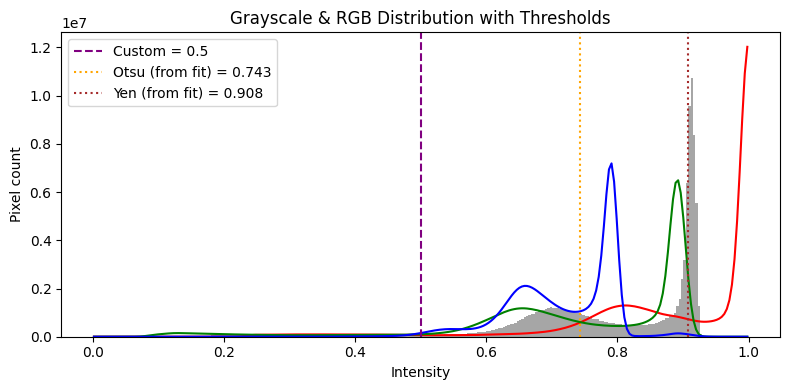

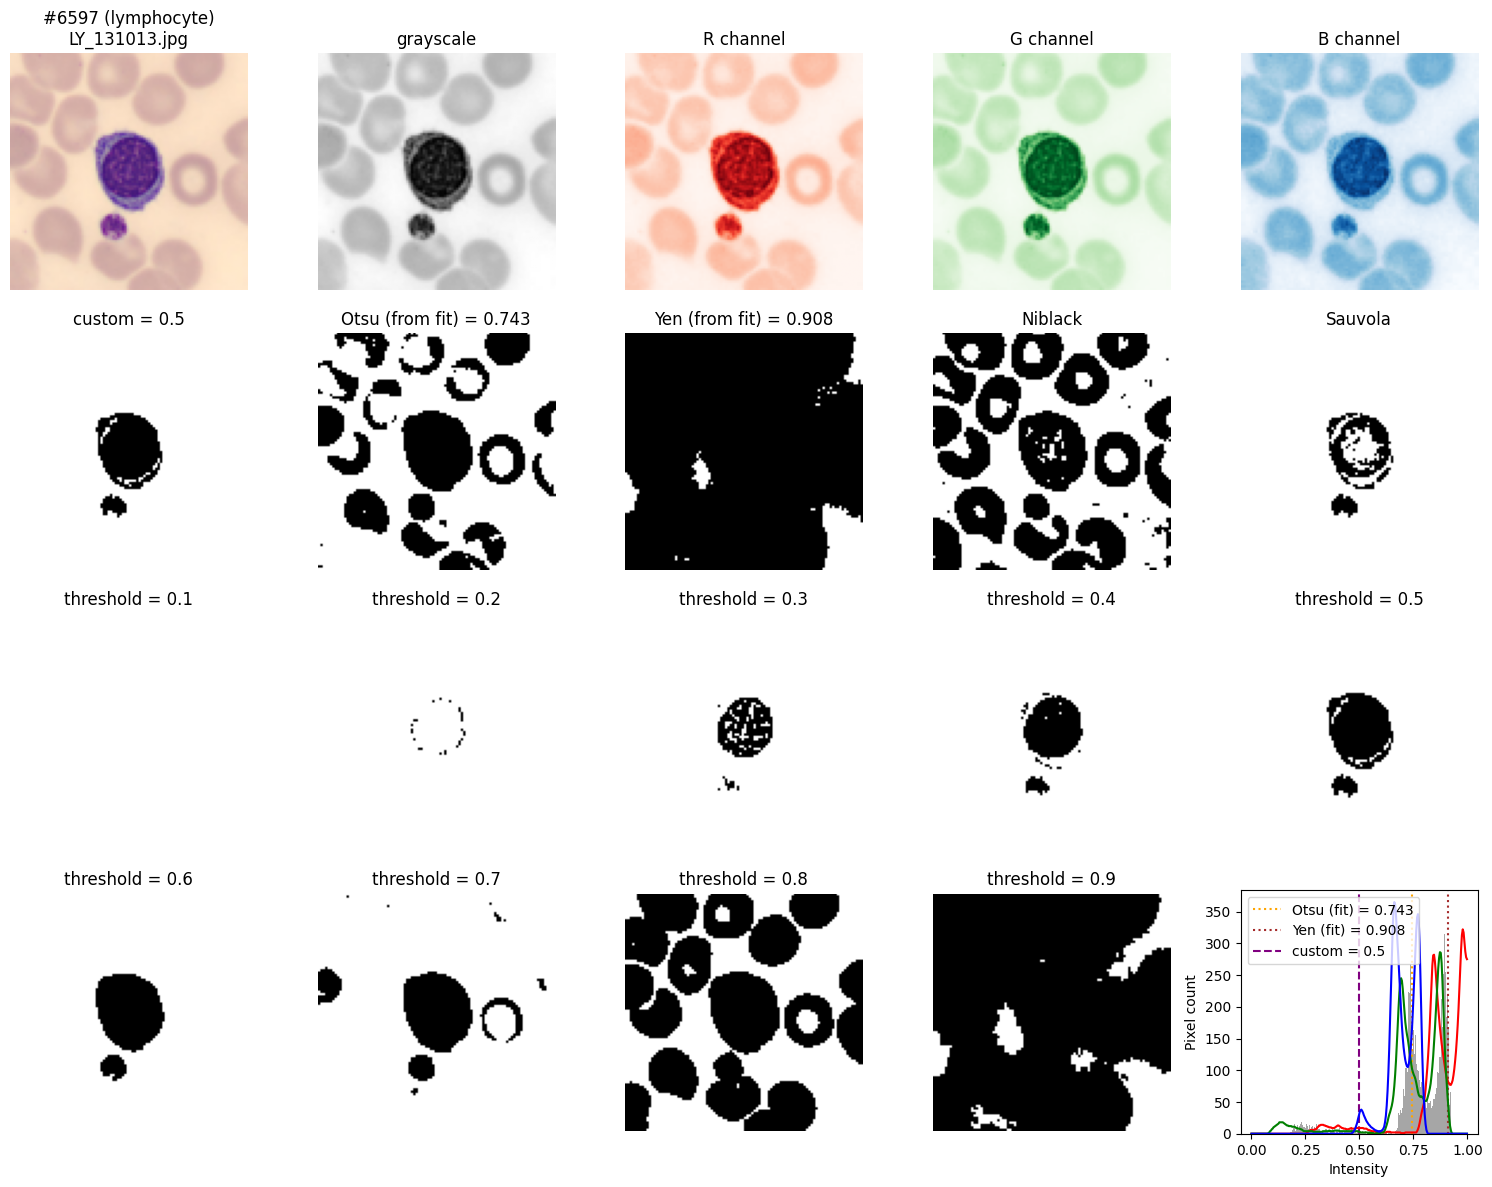

In [ ]:
ib = ImagesBinarizer()
ib.fit(X_res_train)
ib.plot_threshold_analysis(X_res_train)
ib.show_sample(X_res_train, y_res_train, names_res_train)


The threshold needs to be set before the first peak to split colored cell pixels from lighter background
The best binarization result is obtained with a global threshold set to 0.5

### Binarization

In [ ]:
best_threshold = 0.5

ib = ImagesBinarizer(best_threshold)

X_bin_train = ib.fit_transform(X_res_train)
X_bin_valid = ib.transform(X_res_valid)
X_bin_test = ib.transform(X_res_test)
X_bin_train_valid = ib.transform(X_res_train_valid)

X_bin_train_valid_flat = flatten_dataset(X_bin_train_valid)
X_bin_train_flat = flatten_dataset(X_bin_train)

y_bin_train_valid = y_res_train_valid
y_bin_train = y_res_train
y_bin_valid = y_res_valid
y_bin_test = y_res_test

names_bin_train = names_res_train
names_bin_valid = names_res_valid
names_bin_test = names_res_test


Otsu threshold = 0.7430742218137255
Yen threshold  = 0.908203125


# Machine Learning

## Evaluate performance

TODO : early_stopping_rounds pour XGB, CAT et LGBM à 5 ou 10 et remettre iterator par défaut !?

TODO : ajouter dataset réduction de dimension par PCA

### Define ML models

In [ ]:
# Random Forest
RF = ensemble.RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)


# Support Vector Machine
SVM = SVC(random_state=random_state)
# le paramètre n_jobs n'existe pas dans SVC car il utilise un seul cœur CPU

# k-Nearest Neighbors
KNN = KNeighborsClassifier(n_jobs=n_jobs)
# le paramètre random_state n'existe pas dans KNN car c’est un algorithme non probabiliste et déterministe

# XGBoost
XGB = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=20,  # default = 100
    n_jobs=n_jobs,
    tree_method="hist",
    device="cuda",  # or cuda for gpu
    random_state=random_state,
)

# CatBoost
CAT = CatBoostClassifier(
    iterations=20,  # default = 1000
    thread_count=n_jobs,
    random_seed=random_state,
    verbose=100 * int(verbose),
)

# LightGBM
LGBM = LGBMClassifier(
    n_estimators=20,  # default = 100
    # num_class=len(set(y_res_train)),
    objective="multiclass",
    n_jobs=n_jobs,
    random_state=random_state,
    verbose=int(verbose),
)


### Select models

In [ ]:
models = [RF, KNN, XGB]  # default : models = [RF, SVM, KNN, XGB, LGBM, CAT]


### Define datasets

In [ ]:
RES = (X_res_train, X_res_valid, y_res_train, y_res_valid, "Resized")
SAM = (X_sample_train, X_sample_valid, y_sample_train, y_sample_valid, "Sample")
BIN = (X_bin_train, X_bin_valid, y_bin_train, y_bin_valid, "Binarized")


### Select datasets

In [ ]:
datasets = [BIN]  # default = [RES, SAM, BIN]


### Evaluate performances

In [ ]:
if PERF_ML:
    ML_global_perf = evaluate_ML_global(
        models, datasets, balanced_weights=True, verbose=True
    )


## Fine tuning by Cross Validation
Random Forest classifier with Resized dataset
XGBoost classifier et LGBM with Binarized dataset

TODO : il faut fusionner train et valid car la CV génère son set de validation !

In [ ]:
encoder = LabelEncoder()
y_res_encoded = encoder.fit_transform(y_res)
y_res_train_valid_encoded = encoder.transform(y_res_train_valid)
y_sample_train_valid_encoded = encoder.transform(y_sample_train_valid)
y_bin_train_valid_encoded = encoder.transform(y_bin_train_valid)

# Sauvegarder
path = os.path.join(PATH_JOBLIB, "labelencoder_trainvalid_v1.joblib")
joblib.dump(encoder, path)


['/home/did/Windows/Downloads/joblib/labelencoder_trainvalid_v1.joblib']

In [ ]:
# conversion des 'numpy.uint8' en float32 normalisé pour faciliter le traitement par classifier

X_res_flat = X_res_flat.astype("float32") / 255.0

X_res_train_valid_flat = X_res_train_valid_flat.astype("float32") / 255.0
X_res_train_flat = X_res_train_flat.astype("float32") / 255.0
X_res_valid_flat = X_res_valid_flat.astype("float32") / 255.0
X_res_test_flat = X_res_test_flat.astype("float32") / 255.0

X_sample_train_valid_flat = X_sample_train_valid_flat.astype("float32") / 255.0
X_sample_train_flat = X_sample_train_flat.astype("float32") / 255.0

# X_bin ont des valeurs binaires uint8 sont converties en float32 mais pas /255.0
X_bin_train_valid_flat = X_bin_train_valid_flat.astype("float32")
X_bin_train_flat = X_bin_train_flat.astype("float32")


### Random Forest

#### using RandomizedSearchCV (faster and larger)
with StratifiedKFold

In [ ]:
# start_time = time.perf_counter()

rf = ensemble.RandomForestClassifier(n_jobs=1, random_state=random_state)
# n_jobs = 1 car le parallélisme se fera sur le CV

param_dist = {
    "n_estimators": randint(50, 1001),  # entre 100 et 500 arbres
    "max_features": ["sqrt", "log2"],  # mix catégorique + floats
    "max_depth": [None, 10, 20, 30, 50, 100],
    "min_samples_split": randint(2, 21),  # entre 2 et 10
    "min_samples_leaf": randint(1, 10),  # entre 1 et 4
    "bootstrap": [True, False],
}

cv = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=random_state
)  # ici on peut utiliser cv=5 car on limite le nombre de candidats avec n_iter

scoring = ["accuracy", "balanced_accuracy", "neg_log_loss"]

randomized_CV_RF = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,  # 500,  # commencer par 1 puis adapter selon ton temps disponible
    cv=cv,
    n_jobs=n_jobs,
    random_state=random_state,
    verbose=int(verbose),
    scoring=scoring,
    refit="neg_log_loss",  # on priorise logloss a accuracy pendant le tuning
)

best_params = {}  # to remove type warning...

if TUNE_RF:
    if TUNE_DS == "RES":
        randomized_CV_RF.fit(X_res_train_flat, y_res_train)
    elif TUNE_DS == "SAM":
        randomized_CV_RF.fit(X_sample_train_flat, y_sample_train)
    elif TUNE_DS == "BIN":
        randomized_CV_RF.fit(X_bin_train_flat, y_bin_train)

    # stop_time = time.perf_counter()

    best_params = randomized_CV_RF.best_params_
    # best_randomizedCV_rf = randomized_CV_RF.best_estimator_

    # duration = int(stop_time - start_time)
    # print_CV_results(randomized_CV_RF, duration)

    # sauvegarder csv
    results_df = pd.DataFrame(randomized_CV_RF.cv_results_)
    results_df["mean_test_logloss"] = -results_df["mean_test_neg_log_loss"]
    results_df["std_test_logloss"] = results_df["std_test_neg_log_loss"]
    results_df["rank_test_logloss"] = results_df["rank_test_neg_log_loss"]
    results_df.sort_values(by="mean_test_logloss", inplace=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    path = os.path.join(PATH_JOBLIB, f"rf_random_cv_results_{timestamp}.csv")
    results_df.to_csv(path, index=False)

    if verbose:
        display(
            results_df[
                [
                    "params",
                    "mean_test_accuracy",
                    "mean_test_balanced_accuracy",
                    "mean_test_logloss",
                ]
            ].head(10)
        )


#### using GridSearchCV (exhaustive)
with StratifiedKFold

In [ ]:
# start_time = time.perf_counter()
if TUNE_RF:
    rf = ensemble.RandomForestClassifier(n_jobs=1, random_state=random_state)
    # n_jobs = 1 car le parallélisme se fera sur le CV

    """
    param_grid = {
        "n_estimators": [100, 200, 300],  # nombre d’arbres
        "max_depth": [None, 20, 40],  # profondeur max (None = jusqu'à pureté)
        "min_samples_split": [2, 5, 10],  # min samples pour un split
        "min_samples_leaf": [1, 2, 4],  # min samples dans une feuille
        "max_features": ["sqrt", "log2"],  # nombre de features à tester à chaque split
    }
    """
    param_grid = {
        "n_estimators": [
            max(100, best_params["n_estimators"] - 50),
            best_params["n_estimators"],
            best_params["n_estimators"] + 50,
        ],
        "max_features": (
            ["sqrt", "log2"]
            if best_params["max_features"] in ["sqrt", "log2"]
            else [best_params["max_features"]]
        ),
        "max_depth": (
            [
                max(1, best_params["max_depth"] - 5),
                best_params["max_depth"],
                best_params["max_depth"] + 5,
            ]
            if best_params["max_depth"] is not None
            else [50, 100, None]
        ),
        "min_samples_split": sorted(
            {
                max(2, best_params["min_samples_split"] - 1),
                best_params["min_samples_split"],
                best_params["min_samples_split"] + 1,
            }
        ),
        "min_samples_leaf": sorted(
            {
                max(1, best_params["min_samples_leaf"] - 1),
                best_params["min_samples_leaf"],
                best_params["min_samples_leaf"] + 1,
            }
        ),
        "bootstrap": [best_params["bootstrap"]],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    scoring = ["accuracy", "balanced_accuracy", "neg_log_loss"]

    grid_CV_RF = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scoring,
        refit="neg_log_loss",
        cv=cv,
        n_jobs=n_jobs,
        verbose=int(verbose),
    )

    if TUNE_DS == "RES":
        grid_CV_RF.fit(X_res_train_flat, y_res_train)
    elif TUNE_DS == "SAM":
        grid_CV_RF.fit(X_sample_train_flat, y_sample_train)
    elif TUNE_DS == "BIN":
        grid_CV_RF.fit(X_bin_train_flat, y_bin_train)

    # if verbose:
    # stop_time = time.perf_counter()
    # duration = int(stop_time - start_time)
    # print_CV_results(grid_CV_RF, duration)

    best_rf_grid_cv = grid_CV_RF.best_estimator_

    # sauvegarder csv
    results_df = pd.DataFrame(grid_CV_RF.cv_results_)
    results_df["mean_test_logloss"] = -results_df["mean_test_neg_log_loss"]
    results_df["std_test_logloss"] = results_df["std_test_neg_log_loss"]
    results_df["rank_test_logloss"] = results_df["rank_test_neg_log_loss"]
    results_df.sort_values(by="mean_test_logloss", inplace=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    path = os.path.join(PATH_JOBLIB, f"rf_grid_cv_results_{timestamp}.csv")
    results_df.to_csv(path, index=False)

    if verbose:
        display(
            results_df[
                [
                    "params",
                    "mean_test_accuracy",
                    "mean_test_balanced_accuracy",
                    "mean_test_logloss",
                ]
            ].head(10)
        )

    # sauvegarder
    path = os.path.join(PATH_JOBLIB, "rf_tuned_gridcv_trainvalid_fitted_v1.joblib")
    joblib.dump(best_rf_grid_cv, path)


### XGBoost

#### using RandomizedSearchCV

In [ ]:
# NE PERMET PAS DE FAIRE DU EARLY STOPPING et FAIT mourir LE NOYAU
# FAIRE GRID SEARCH ET RANDOM SEARCH MANUELLEMENT
"""
start_time = time.perf_counter()

XGB = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=20,  # default = 100
    n_jobs=1,
    tree_method="hist",
    device="cuda",
    random_state=random_state,
)
# n_jobs = 1 car le parallélisme se fera sur le CV

param_dist = {
    "max_depth": [3, 6],  # 1 Profondeur max des arbres: 3 à 6 = limite overfitting
    "learning_rate": [
        0.1,
        0.01,
    ],  # 2 Taille des pas de gradient: 0.1 (rapide), 0.01 (plus précis)
    "subsample": [
        0.8
    ],  # [0.8, 1.0],          #4 Pourcentage d'échantillons: 0.8 pour du bagging
    "colsample_bytree": [
        0.6
    ],  # [0.6, 0.8],          #5 Proportion de features utilisées par arbre	0.6-0.8 (cruciale avec beaucoup de features)
    "gamma": [
        0,
        1,
    ],  # 6 Gain minimal pour scinder un nœud: 0 ou 1 (régularisation légère)
}

cv = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=random_state
)  # ici on peut utiliser cv=5 car on limite le nombre de candidats avec n_iter

randomized_CV = RandomizedSearchCV(
    estimator=XGB,
    param_distributions=param_dist,
    n_iter=1,  # commencer par 1 puis adapter selon ton temps disponible
    cv=cv,
    n_jobs=n_jobs,
    random_state=random_state,
    verbose=3 * int(verbose),
)

encoder = LabelEncoder()


if TUNE_XGB:
    if not USE_SAMPLE:
        y_enc = encoder.fit_transform(y_res_train_valid)
        randomized_CV.fit(X_res_train_valid_flat, y_enc)
    else:
        y_enc = encoder.fit_transform(y_sample_train_valid)
        randomized_CV.fit(X_sample_train_valid_flat, y_enc)
    best_randomizedCV_rf = randomized_CV.best_estimator_
    if verbose:
        stop_time = time.perf_counter()
        duration = int(stop_time - start_time)
        print_CV_results(randomized_CV, duration)
"""


'\nstart_time = time.perf_counter()\n\nXGB = XGBClassifier(\n    objective="multi:softprob",\n    eval_metric="mlogloss",\n    n_estimators=20,  # default = 100\n    n_jobs=1,\n    tree_method="hist",\n    device="cuda",\n    random_state=random_state,\n)\n# n_jobs = 1 car le parallélisme se fera sur le CV\n\nparam_dist = {\n    "max_depth": [3, 6],  # 1 Profondeur max des arbres: 3 à 6 = limite overfitting\n    "learning_rate": [\n        0.1,\n        0.01,\n    ],  # 2 Taille des pas de gradient: 0.1 (rapide), 0.01 (plus précis)\n    "subsample": [\n        0.8\n    ],  # [0.8, 1.0],          #4 Pourcentage d\'échantillons: 0.8 pour du bagging\n    "colsample_bytree": [\n        0.6\n    ],  # [0.6, 0.8],          #5 Proportion de features utilisées par arbre\t0.6-0.8 (cruciale avec beaucoup de features)\n    "gamma": [\n        0,\n        1,\n    ],  # 6 Gain minimal pour scinder un nœud: 0 ou 1 (régularisation légère)\n}\n\ncv = StratifiedKFold(\n    n_splits=5, shuffle=True, ran

using xgb.cv()

In [ ]:
start_time = time.perf_counter()

if TUNE_XGB:

    if TUNE_DS == "RES":
        X_flat = X_res_train_valid_flat
        y_enc = encoder.transform(y_res_train_valid)
    elif TUNE_DS == "SAM":
        X_flat = X_sample_train_valid_flat
        y_enc = encoder.transform(y_sample_train_valid)
    elif TUNE_DS == "BIN":
        X_flat = X_bin_train_valid_flat
        y_enc = encoder.transform(y_bin_train_valid)

    param_grid = {
        "max_depth": [3, 6],  # 1 Profondeur max des arbres: 3 à 6 = limite overfitting
        "learning_rate": [
            0.1,
            0.01,
        ],  # 2 Taille des pas de gradient: 0.1 (rapide), 0.01 (plus précis)
        "subsample": [
            0.8
        ],  # [0.8, 1.0],          #4 Pourcentage d’échantillons: 0.8 pour du bagging
        "colsample_bytree": [
            0.6
        ],  # [0.6, 0.8],          #5 Proportion de features utilisées par arbre	0.6–0.8 (cruciale avec beaucoup de features)
        "gamma": [
            0,
            1,
        ],  # 6 Gain minimal pour scinder un nœud: 0 ou 1 (régularisation légère)
    }

    weights = compute_sample_weight("balanced", y_enc)  # type: ignore
    dtrain = xgb.DMatrix(X_flat, label=y_enc, weight=weights)  # type: ignore

    num_boost_round = 5  # 50 ou 100
    nfold = 3  # ou 5

    best_score = float("inf")  # on cherche à minimiser score = mlogloss
    best_idx = None
    best_logloss_std = None
    best_acc_mean = None
    best_acc_std = None
    best_params = None
    best_num_boost_round = None
    all_results = []

    n_candidates = 1
    for v in param_grid.values():
        n_candidates *= len(v)

    for idx, (
        max_depth,
        learning_rate,
        subsample,
        colsample_bytree,
        gamma,
    ) in enumerate(
        tqdm(
            itertools.product(*param_grid.values()),
            total=n_candidates,
            desc="Grid search",
        )
    ):

        params = {
            "objective": "multi:softprob",
            "num_class": len(set(y_enc)),  # type: ignore
            "eval_metric": [
                "merror",
                "mlogloss",
            ],  # early stopping sur merror (la dernière)
            "n_jobs": n_jobs,
            "verbosity": int(
                verbose
            ),  # The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
            "seed": random_state,
            "tree_method": "hist",  # réduit considérablement la RAM utilisée au détriment d’un temps de training un peu plus long
            "device": "cuda",  # not enough memory for cuda
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "gamma": gamma,
        }

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,  # ou 100
            nfold=nfold,
            stratified=True,
            shuffle=True,
            early_stopping_rounds=5,  # ou 10
            metrics=["merror", "mlogloss"],  # pour les deux colonnes dans le CV
            seed=random_state,
            verbose_eval=5 * int(verbose),
        )  # log every 5 rounds

        best_round_idx = cv_results["test-mlogloss-mean"].idxmin()  # type: ignore # indice du meilleur round (min logloss)
        best_round_logloss_mean = cv_results.loc[best_round_idx, "test-mlogloss-mean"]  # type: ignore # logloss moyenne au meilleur round
        best_round_logloss_std = cv_results.loc[best_round_idx, "test-mlogloss-std"]  # type: ignore
        best_round_acc_mean = 1 - cv_results.loc[best_round_idx, "test-merror-mean"]  # type: ignore # accuracy moyenne au meilleur round
        best_round_acc_std = cv_results.loc[best_round_idx, "test-merror-std"]  # type: ignore # std de l’erreur au meilleur round = std de l'accuracy
        best_round_num_boost_round = best_round_idx + 1  # type: ignore
        # +1 car idxmin() retourne l'index (0-based)

        all_results.append(
            {
                "idx": idx,
                "params": params,
                "logloss_mean": best_round_logloss_mean,
                "logloss_std": best_round_logloss_std,
                "acc_mean": best_round_acc_mean,
                "acc_std": best_round_acc_std,
                "num_boost_round": best_round_num_boost_round,
            }
        )

        if best_round_logloss_mean < best_score:  # type: ignore
            best_idx = idx
            best_score = best_round_logloss_mean  # logloss de la meilleure combinaison de paramètres rencontrée jusqu'ici
            best_logloss_std = best_round_logloss_std
            best_acc_mean = best_round_acc_mean
            best_acc_std = best_round_acc_std
            best_params = params
            best_num_boost_round = best_round_num_boost_round

    if verbose:
        stop_time = time.perf_counter()
        duration = stop_time - start_time
        print(f"📊 XGBClassifier fitted using CV in {int(duration)}s")
        print(f"{nfold} folds for each of {n_candidates} candidates, totalling {nfold*n_candidates} fits")  # type: ignore
        print(f"Mean duration per fit: {duration/(nfold*n_candidates):.1f}s")
        print(f"Best candidate is #{best_idx} (best mlogloss on test = {best_score})")
        print(f"\t• mean test logloss : {best_score:.4f}")
        print(f"\t• std  test logloss : {best_logloss_std:.4f}")
        print(f"\t• mean test accuracy: {best_acc_mean:.4f}")
        print(f"\t• std  test accuracy: {best_acc_std:.4f}")
        print("\t• params:", best_params)
        print("\t• number of trees:", best_num_boost_round)

    assert best_params is not None, "Grid search failed to find any parameters"
    best_xgb = XGBClassifier(**best_params, n_estimators=best_num_boost_round)  # type: ignore

    all_results = sorted(
        all_results, key=lambda x: x["logloss_mean"]
    )  # tri par logloss croissante
    print("\nTop 5 configurations:")
    for r in all_results[:5]:
        print(
            f"• logloss={r['logloss_mean']:.4f}, acc={r['acc_mean']:.4f}, rounds={r['num_boost_round']}, depth={r['params']['max_depth']}, lr={r['params']['learning_rate']}"
        )

    results_df = pd.DataFrame(all_results)
    display(results_df.head())

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    path = os.path.join(PATH_JOBLIB, f"xgb_grid_cv_results_{timestamp}.csv")
    results_df.to_csv(path, index=False)

    # Sauvegarder le modèle non fitted
    best_xgb.set_params(n_jobs=1)
    # best_xgb.set_params(device="cuda")
    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_trainvalid_unfit_v1.joblib")
    joblib.dump(best_xgb, path)


## Entraînement et Calibration par CV
on Train+Valid sets

### Random Forest

In [ ]:
if CALIB_RF:

    # charger

    path = os.path.join(PATH_JOBLIB, "rf_tuned_gridcv_trainvalid_fitted_v1.joblib")
    best_rf_grid_cv = joblib.load(path)

    model = clone(best_rf_grid_cv)
    # clone pour avoir le modèle non entraîné (a priori inutile car CalibratedClassifierCV utilise un clone de l'estimator...)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    calibrated_rf = CalibratedClassifierCV(
        estimator=model,
        method="isotonic",
        cv=cv,  # on pourrait utiliser cv=5 directement qui est stratifié mais sans shuffle...
        ensemble=False,  # ensemble = True est plus performant mais produit 5 couples (estimator, calibrator...)
        n_jobs=n_jobs,
    )

    print(calibrated_rf)

    if TUNE_DS == "RES":
        sample_weights = compute_sample_weight("balanced", y_res_train_valid_encoded)
        calibrated_rf.fit(
            X_res_train_valid_flat,
            y_res_train_valid_encoded,
            sample_weight=sample_weights,
        )
    elif TUNE_DS == "SAM":
        sample_weights = compute_sample_weight("balanced", y_sample_train_valid_encoded)
        calibrated_rf.fit(
            X_sample_train_valid_flat,
            y_sample_train_valid_encoded,
            sample_weight=sample_weights,
        )
    elif TUNE_DS == "BIN":
        sample_weights = compute_sample_weight("balanced", y_bin_train_valid_encoded)
        calibrated_rf.fit(
            X_bin_train_valid_flat,
            y_bin_train_valid_encoded,
            sample_weight=sample_weights,
        )

    # sauvegarder
    path = os.path.join(
        PATH_JOBLIB, "rf_final_calibrated_isotonic_cv_trainvalid_v1.joblib"
    )
    joblib.dump(calibrated_rf, path)


### XGBoost

In [ ]:
if CALIB_XGB:
    # charger
    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_trainvalid_unfit_v1.joblib")
    best_xgb = joblib.load(path)

    model = best_xgb  # ici on ne clone pas car clone fait bug + inutile car xgb est unfitted

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    calibrated_xgb = CalibratedClassifierCV(
        estimator=model,
        method="isotonic",
        cv=cv,
        ensemble=False,
        n_jobs=n_jobs,
    )

    print(calibrated_xgb)

    if TUNE_DS == "RES":
        sample_weights = compute_sample_weight("balanced", y_res_train_valid_encoded)
        calibrated_xgb.fit(
            X_res_train_valid_flat,
            y_res_train_valid_encoded,
            sample_weight=sample_weights,
        )
    elif TUNE_DS == "SAM":
        sample_weights = compute_sample_weight("balanced", y_sample_train_valid_encoded)
        calibrated_xgb.fit(
            X_sample_train_valid_flat,
            y_sample_train_valid_encoded,
            sample_weight=sample_weights,
        )
    elif TUNE_DS == "BIN":
        sample_weights = compute_sample_weight("balanced", y_bin_train_valid_encoded)
        calibrated_xgb.fit(
            X_bin_train_valid_flat,
            y_bin_train_valid_encoded,
            sample_weight=sample_weights,
        )

    # sauvegarder
    path = os.path.join(
        PATH_JOBLIB, "xgb_final_calibrated_isotonic_cv_trainvalid_v1.joblib"
    )
    joblib.dump(calibrated_xgb, path)


In [ ]:
"""
if CALIB:

    # charger
    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_trainvalid_unfit_v1.joblib")
    best_xgb = joblib.load(path)

    model = clone(best_xgb)
    print(model)

    y_res_train_encoded = encoder.transform(y_res_train)

    sample_weights = compute_sample_weight("balanced", y_res_train_encoded)
    model.fit(X_res_train_flat, y_res_train_encoded, sample_weight=sample_weights)

    # sauvegarder
    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_fitted_train_v1.joblib")
    joblib.dump(model, path)
"""


'\nif CALIB:\n\n    # charger\n    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_trainvalid_unfit_v1.joblib")\n    best_xgb = joblib.load(path)\n\n    model = clone(best_xgb)\n    print(model)\n\n    y_res_train_encoded = encoder.transform(y_res_train)\n\n    sample_weights = compute_sample_weight("balanced", y_res_train_encoded)\n    model.fit(X_res_train_flat, y_res_train_encoded, sample_weight=sample_weights)\n\n    # sauvegarder\n    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_fitted_train_v1.joblib")\n    joblib.dump(model, path)\n'

In [ ]:
"""
if CALIB:

    # charger
    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_fitted_train_v1.joblib")
    model = joblib.load(path)

    frozen_model = FrozenEstimator(model)

    calibrated_xgb = CalibratedClassifierCV(
        estimator=frozen_model,  # type: ignore
        method="sigmoid",
        cv=None,
        n_jobs=n_jobs,
    )

    y_res_valid_encoded = encoder.transform(y_res_valid)

    sample_weights = compute_sample_weight("balanced", y_res_valid_encoded)
    calibrated_xgb.fit(
        X_res_valid_flat, y_res_valid_encoded, sample_weight=sample_weights
    )

    # sauvegarder
    path = os.path.join(PATH_JOBLIB, "xgb_calibrated_sigmoid_valid_v1.joblib")
    joblib.dump(calibrated_xgb, path)
"""


'\nif CALIB:\n\n    # charger\n    path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_fitted_train_v1.joblib")\n    model = joblib.load(path)\n\n    frozen_model = FrozenEstimator(model)\n\n    calibrated_xgb = CalibratedClassifierCV(\n        estimator=frozen_model,  # type: ignore\n        method="sigmoid",\n        cv=None,\n        n_jobs=n_jobs,\n    )\n\n    y_res_valid_encoded = encoder.transform(y_res_valid)\n\n    sample_weights = compute_sample_weight("balanced", y_res_valid_encoded)\n    calibrated_xgb.fit(\n        X_res_valid_flat, y_res_valid_encoded, sample_weight=sample_weights\n    )\n\n    # sauvegarder\n    path = os.path.join(PATH_JOBLIB, "xgb_calibrated_sigmoid_valid_v1.joblib")\n    joblib.dump(calibrated_xgb, path)\n'

avec StratifiedKFold

charger  
path = os.path.join(PATH_JOBLIB, "xgb_tuned_gridcv_trainvalid_unfit_v1.joblib")
best_xgb = joblib.load(path)

best_xgb.set_params(n_jobs=1)
best_xgb.set_params(device="cuda")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

model = clone(best_xgb)  # best_xgb n'est pas fitted mais pour homogénéiser...
print(model)

calibrated_xgb_cv = CalibratedClassifierCV(
    estimator=model,
    method="sigmoid",  # ou sigmoid (plus rapide et plus robuste sur peu de données)
    cv=cv,  # on pourrait utiliser cv=5 directement qui est stratifié mais sans shuffle...
    n_jobs=n_jobs,
)

calibrated_xgb_cv.fit(X_res_train_valid_flat, y_res_train_valid_encoded)

sauvegarder  
path = os.path.join(
    PATH_JOBLIB, "xgb_tuned_calibrated_sigmoid_cv_trainvalid_v1.joblib"
)
joblib.dump(calibrated_xgb_cv, path)


## Final evaluation
 on Test set

### Random Forest

In [ ]:
if FINAL_EVAL:

    # Charger
    path = os.path.join(
        PATH_JOBLIB, "rf_final_calibrated_isotonic_cv_trainvalid_v1.joblib"
    )
    calibrated_rf = joblib.load(path)

    path = os.path.join(PATH_JOBLIB, "labelencoder_trainvalid_v1.joblib")
    encoder = joblib.load(path)

    model = calibrated_rf  # calibré et entraîné sur labels encodés
    print(model)

    # Prédiction sur test jamais utilisé jusqu'à présent
    y_res_pred_encoded = model.predict(X_res_test_flat)

    y_res_test_encoded = encoder.transform(y_res_test)
    accuracy = accuracy_score(y_res_test_encoded, y_res_pred_encoded)
    balanced_accuracy = balanced_accuracy_score(y_res_test_encoded, y_res_pred_encoded)

    y_res_prob_encoded = model.predict_proba(X_res_test_flat)
    loss = log_loss(y_res_test_encoded, y_res_prob_encoded)

    y_res_pred = encoder.inverse_transform(y_res_pred_encoded)
    cm = pd.crosstab(y_res_test, y_res_pred)
    # Matrice de confusion normalisée
    cm_norm = cm.div(cm.sum(axis=1), axis=0)
    dict_report = classification_report(y_res_test, y_res_pred, output_dict=True)
    dict_report["balanced_accuracy"] = balanced_accuracy  # type: ignore
    dict_report["log_loss"] = loss  # type: ignore
    df_report = pd.DataFrame(dict_report).T

    if verbose:
        print("loss:", loss)
        print("accuracy:", accuracy)
        print("balanced accuracy:", balanced_accuracy)
        display(cm)
        display(df_report.round(3))

    # Sauvegarder csv

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    path = os.path.join(PATH_JOBLIB, f"rf_confusion_matrix_{timestamp}.csv")
    cm.to_csv(path)

    cm_norm.to_csv(
        os.path.join(PATH_JOBLIB, f"rf_confusion_matrix_normalized_{timestamp}.csv")
    )

    path = os.path.join(PATH_JOBLIB, f"rf_classification_report_{timestamp}.csv")
    df_report.to_csv(path)

    # Visualisation confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Normalized Confusion Matrix")
    plt.show()


### XGBoost

In [ ]:
if FINAL_EVAL:

    # Charger

    path = os.path.join(
        PATH_JOBLIB, "xgb_final_calibrated_isotonic_cv_trainvalid_v1.joblib"
    )
    calibrated_xgb = joblib.load(path)

    model = calibrated_xgb  # calibré et entraîné sur labels encodés
    print(model)

    y_res_pred_encoded = model.predict(X_res_test_flat)
    y_res_test_encoded = encoder.transform(y_res_test)

    accuracy = accuracy_score(y_res_test_encoded, y_res_pred_encoded)
    balanced_accuracy = balanced_accuracy_score(y_res_test_encoded, y_res_pred_encoded)

    y_res_prob_encoded = model.predict_proba(X_res_test_flat)
    loss = log_loss(y_res_test_encoded, y_res_prob_encoded)

    y_res_pred = encoder.inverse_transform(y_res_pred_encoded)
    cm = pd.crosstab(y_res_test, y_res_pred)
    # Matrice de confusion normalisée
    cm_norm = cm.div(cm.sum(axis=1), axis=0)

    dict_report = classification_report(y_res_test, y_res_pred, output_dict=True)
    # Ajout de balanced accuracy au classification report
    dict_report["balanced_accuracy"] = balanced_accuracy  # type: ignore
    dict_report["log_loss"] = loss  # type: ignore
    df_report = pd.DataFrame(dict_report).T

    if verbose:
        print("loss:", loss)
        print("accuracy:", accuracy)
        print("balanced accuracy:", balanced_accuracy)
        display(cm)
        display(df_report.round(3))

    # Sauvegarder csv

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    path = os.path.join(PATH_JOBLIB, f"xgb_confusion_matrix_{timestamp}.csv")
    cm.to_csv(path)

    cm_norm.to_csv(
        os.path.join(PATH_JOBLIB, f"xgb_confusion_matrix_normalized_{timestamp}.csv")
    )

    path = os.path.join(PATH_JOBLIB, f"xgb_classification_report_{timestamp}.csv")
    df_report.to_csv(path)

    # Visualisation confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Normalized Confusion Matrix")
    plt.show()


# Deep Learning

#TODO: tuning par KerasTuner : faire varier le taux de dropout apres dense 1 et dense 2 
(et le nb de couches defrozen)

## VGG16

Génération d'images à partir d'un répertoire d'images d’entraînement et de valid

In [ ]:
base_model = VGG16(
    weights="imagenet", include_top=False
)  # par défaut input_shape = (224,224,3)

n_layers = len(base_model.layers)
conv_layers = [layer for layer in base_model.layers if "conv" in layer.name]
n_conv_layers = len(conv_layers)
print(
    f"{base_model.name} has {n_layers} layers in total, including {n_conv_layers} convolutional layers."
)

target_size = (224, 224)  # optimal pour VGG16


I0000 00:00:1749425223.308364    4691 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6109 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


vgg16 has 19 layers in total, including 13 convolutional layers.


In [ ]:
def DidDataGen(
    directory_train,
    directory_valid,
    directory_test,
    preprocessing_function,
    target_size=(224, 224),
    batch_size=32,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=359,
    horizontal_flip=True,
    vertical_flip=True,
):

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        shear_range=shear_range,  # plage d'étirement
        zoom_range=zoom_range,  # plage d'agrandissement
        rotation_range=rotation_range,  # plage de rotation en degré
        horizontal_flip=horizontal_flip,  # retournement horizontal aléatoire
        vertical_flip=vertical_flip,  # retournement vertical aléatoire
    )

    valid_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_generator = train_datagen.flow_from_directory(
        directory=directory_train,
        class_mode="sparse",
        target_size=target_size,
        batch_size=batch_size,
    )

    valid_generator = valid_datagen.flow_from_directory(
        directory=directory_valid,
        class_mode="sparse",
        target_size=target_size,
        batch_size=batch_size,
    )

    test_generator = test_datagen.flow_from_directory(
        directory=directory_test,  # chemin vers ton dossier test
        class_mode="sparse",  # ou "categorical" selon ton modèle / labels
        target_size=target_size,  # la même taille que pour train/valid
        batch_size=batch_size,
        shuffle=False,  # important: ne pas mélanger les données test
    )

    # compte le nb de sous-dossiers dans directory_train
    # n_class = 0
    # for file in os.listdir(directory_train):
    #    d = os.path.join(directory_train, file)
    #    if os.path.isdir(d):
    #        n_class += 1

    return train_generator, valid_generator, test_generator


Création et entraînement de plusieurs modèles VGG16 (à 21 couches) selon différents paramètres :
 * nb de couches defreezées = 4, 12, 21
 * taille du batch = 32 ou 64
 * learning rate évolutif par plateau de val_loss (callback)

In [ ]:
def fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=0,
    learning_rate=1e-4,
    nb_epochs=30,
    # batch_size=32,
) -> Tuple[Any, Any, Tuple]:

    start_time = time.perf_counter()

    n_class = len(train_generator.class_indices)

    # Freeze toutes les couches du base_model
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze les couches convolutionnelles selon n_conv_layers_trainable
    conv_layers = [layer for layer in base_model.layers if "conv" in layer.name]
    for layer in conv_layers[-n_conv_layers_trainable:]:
        layer.trainable = True

    # Callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", min_delta=0.01, mode="min", patience=6, verbose=1
    )
    reduce_learning_rate = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        min_delta=0.01,
        # pas de cooldown nécessaire (patience = 3 suffit à assurer la durée des plateaux de lr donc la stabilité de l’entraînement)
        verbose=1,
    )
    callbacks = [reduce_learning_rate, early_stopping]

    # Construction du modèle
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation="relu"))
    model.add(
        Dropout(rate=0.2)
    )  # ChatPGT recommande 0.3 pour éviter overfitting sur 15k images
    model.add(Dense(512, activation="relu"))
    model.add(
        Dropout(rate=0.2)
    )  # ChatPGT recommande 0.3 pour éviter overfitting sur 15k images
    model.add(Dense(n_class, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Entraînement du modèle avec pondération des classes déséquilibrées

    # labels des images dans le générateur
    labels = train_generator.classes
    # classes uniques
    classes = np.unique(labels)
    # calcul des poids
    class_weights = compute_class_weight(
        class_weight="balanced", classes=classes, y=labels
    )
    # dictionnaire attendu par model.fit()
    class_weight_dict = dict(zip(classes, class_weights))

    print("Entraînement du modèle")
    history = model.fit(
        train_generator,
        epochs=nb_epochs,
        class_weight=class_weight_dict,
        # steps_per_epoch=train_generator.samples // batch_size, #Keras calcule tout seul le steps per epoch ?
        validation_data=valid_generator,
        # validation_steps=valid_generator.samples // batch_size,
        callbacks=callbacks,
    )

    # Courbe de la fonction de loss et accuracy en fonction de l'epoch

    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    plt.figure(figsize=(20, 7))

    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title("Model loss per epoch")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="right")
    plt.grid(True)

    plt.subplot(122)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title("Model accuracy per epoch")
    plt.ylabel("acc")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="right")
    plt.grid(True)

    plt.show()

    print("\n", model.summary())

    duration = int(time.perf_counter() - start_time)

    print(f"\n✅ Modèle entraîné en {duration} s, avec les paramètres initiaux:")
    print(
        f"\t• batch size des flows des image generators : {train_generator.batch_size}"
    )
    print(
        f"\t• nb couches convolutionnelles entraînées   : {n_conv_layers_trainable} / {len(base_model.layers)}"
    )
    print(f"\t• learning rate : {learning_rate}")
    print(f"\t• epochs        : {nb_epochs}")

    # Evaluation du modèle
    print("\nEvaluation du modèle sur l'ensemble de test:")
    score = model.evaluate(test_generator)
    print("loss     =", score[0])
    print("accuracy =", score[1])

    return model, history, score


In [ ]:
batch_size = 32

train_generator, valid_generator, test_generator = DidDataGen(
    PATH_TRAIN,
    PATH_VALID,
    PATH_TEST,
    vgg16_preprocess_input,
    target_size=target_size,
    batch_size=batch_size,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=359,
    horizontal_flip=True,
    vertical_flip=True,
)


Found 12042 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.


Entraînement du modèle
Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 193s 419ms/step - accuracy: 0.1240 - loss: 2.1619 - val_accuracy: 0.1441 - val_loss: 2.0978 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 145s 385ms/step - accuracy: 0.1348 - loss: 2.0787 - val_accuracy: 0.0709 - val_loss: 2.1512 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step - accuracy: 0.1229 - loss: 1.9224 - val_accuracy: 0.1449 - val_loss: 2.0580 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step - accuracy: 0.1301 - loss: 1.9258 - val_accuracy: 0.1883 - val_loss: 2.0582 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 143s 378ms/step - accuracy: 0.1325 - loss: 1.8657 - val_accuracy: 0.1248 - val_loss: 2.0657 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1242 - loss: 1.8554
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━

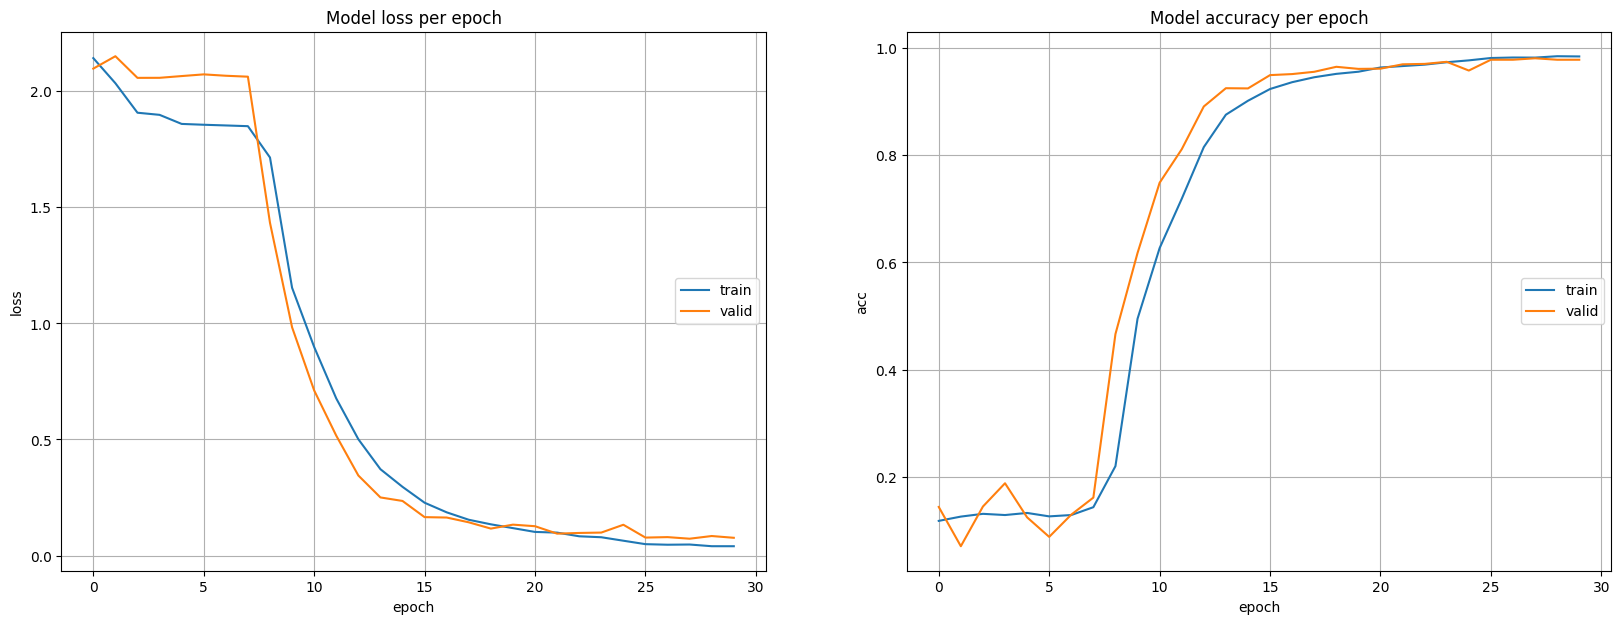

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,308,253 (180.47 MB)

 Trainable params: 15,769,417 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,538,836 (120.31 MB)


 None

✅ Modèle entraîné en 4409 s  avec les paramètres initiaux:
	• couches convolutionnelles entraînées: 0 / 19 
	• learning rate : 0.0001 
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9841 - loss: 0.0461
loss     = 0.060027480125427246
accuracy = 0.9802402257919312


In [ ]:
n_conv_layers_trainable = 0

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle
Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - accuracy: 0.8722 - loss: 0.5066 - val_accuracy: 0.9787 - val_loss: 0.0791 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - accuracy: 0.9743 - loss: 0.0640 - val_accuracy: 0.9740 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9756 - loss: 0.0664 - val_accuracy: 0.9806 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - accuracy: 0.9813 - loss: 0.0484 - val_accuracy: 0.9709 - val_loss: 0.1146 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9803 - loss: 0.0494 - val_accuracy: 0.9783 - val_loss: 0.0701 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9803 - loss: 0.0500
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━━━━━━

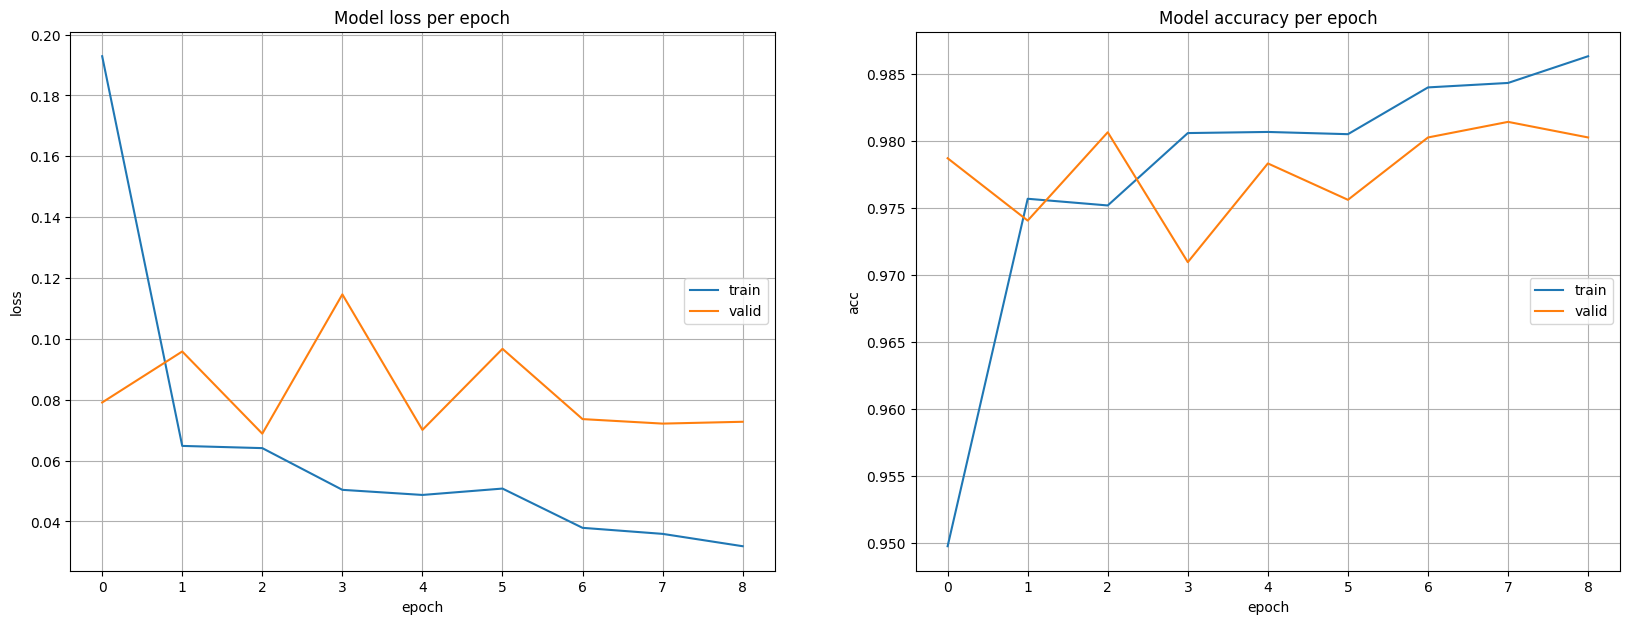

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,318,109 (104.21 MB)

 Trainable params: 5,774,345 (22.03 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

 Optimizer params: 11,548,692 (44.05 MB)


 None

✅ Modèle entraîné en 570 s  avec les paramètres initiaux:
	• couches convolutionnelles entraînées: 2 / 19 
	• learning rate : 0.0001 
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9875 - loss: 0.0382
loss     = 0.05216003209352493
accuracy = 0.983727216720581


In [ ]:
n_conv_layers_trainable = 2

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Found 12042 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.
Entraînement du modèle


/home/did/Windows/Documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 111s 274ms/step - accuracy: 0.5139 - loss: 1.2634 - val_accuracy: 0.8853 - val_loss: 0.3768 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.9302 - loss: 0.1844 - val_accuracy: 0.9508 - val_loss: 0.1782 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 77s 204ms/step - accuracy: 0.9551 - loss: 0.1183 - val_accuracy: 0.9647 - val_loss: 0.1279 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - accuracy: 0.9629 - loss: 0.0994 - val_accuracy: 0.9686 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - accuracy: 0.9667 - loss: 0.0896 - val_accuracy: 0.9570 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - accuracy: 0.9650 - loss: 0.0907 - val_accuracy: 0.9791 - val_loss: 0.0840 - learning_rate: 1.0000e-04
Epoch 7/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 64s 1

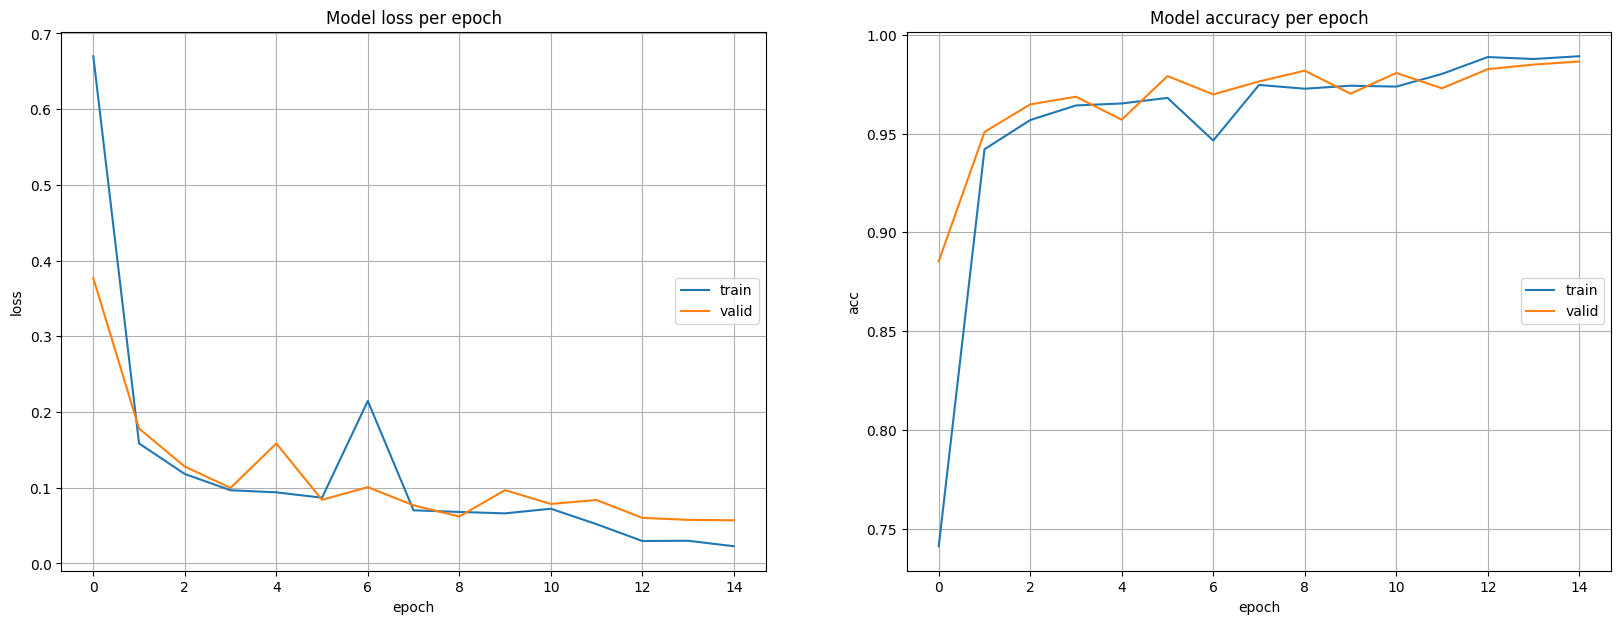

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,757,341 (140.22 MB)

 Trainable params: 10,493,961 (40.03 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

 Optimizer params: 20,987,924 (80.06 MB)


 None

✅ Modèle entraîné en 1050 s  avec les paramètres initiaux:
	• couches convolutionnelles entraînées: 4 / 19 
	• learning rate : 0.0001 
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9900 - loss: 0.0341
loss     = 0.0487530417740345
accuracy = 0.985276997089386


In [ ]:
n_conv_layers_trainable = 4

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle
Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 79s 201ms/step - accuracy: 0.7723 - loss: 0.7712 - val_accuracy: 0.9496 - val_loss: 0.1680 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.9660 - loss: 0.1001 - val_accuracy: 0.9690 - val_loss: 0.1116 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 71s 187ms/step - accuracy: 0.9695 - loss: 0.0839 - val_accuracy: 0.9768 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.9681 - loss: 0.0931 - val_accuracy: 0.9733 - val_loss: 0.0991 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.9674 - loss: 0.0870 - val_accuracy: 0.9655 - val_loss: 0.1224 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9760 - loss: 0.0661
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━━━━━━

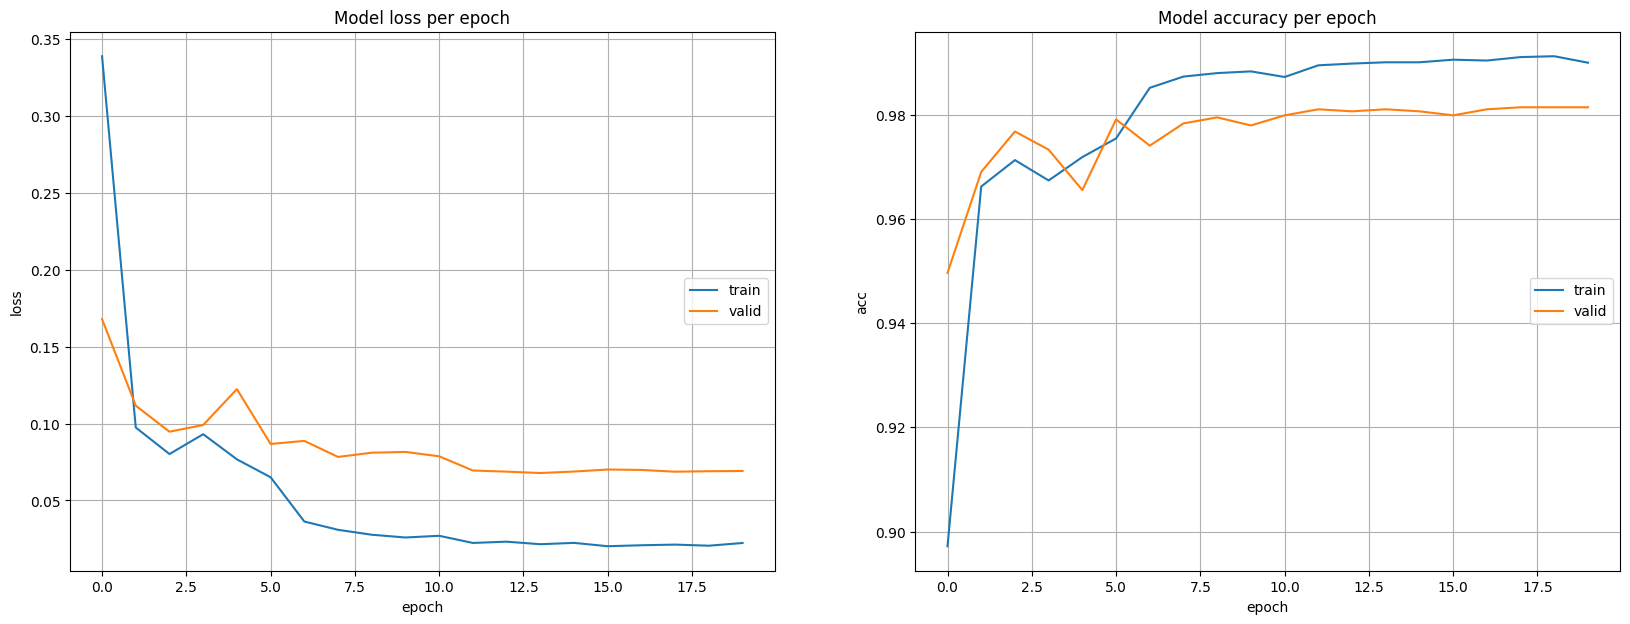

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,837,277 (167.23 MB)

 Trainable params: 14,033,929 (53.54 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 28,067,860 (107.07 MB)


 None

✅ Modèle entraîné en 1417 s  avec les paramètres initiaux:
	• couches convolutionnelles entraînées: 6 / 19 
	• learning rate : 0.0001 
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9906 - loss: 0.0271
loss     = 0.03867190703749657
accuracy = 0.9864393472671509


In [ ]:
n_conv_layers_trainable = 6

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle


/home/did/Windows/Mes documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749425236.675681    5241 service.cc:152] XLA service 0x775ff0026f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749425236.675703    5241 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1749425237.124117    5241 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749425258.915647    5241 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - accuracy: 0.1447 - loss: 2.1571 - val_accuracy: 0.3127 - val_loss: 1.5374 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - accuracy: 0.4032 - loss: 1.2118 - val_accuracy: 0.7280 - val_loss: 0.8200 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - accuracy: 0.8282 - loss: 0.4110 - val_accuracy: 0.9272 - val_loss: 0.2255 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - accuracy: 0.9183 - loss: 0.2179 - val_accuracy: 0.6780 - val_loss: 0.8569 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - accuracy: 0.7556 - loss: 0.6303 - val_accuracy: 0.8958 - val_loss: 0.3303 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - accuracy: 0.9263 - loss: 0.1889 - val_accuracy: 0.9376 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 7/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step -

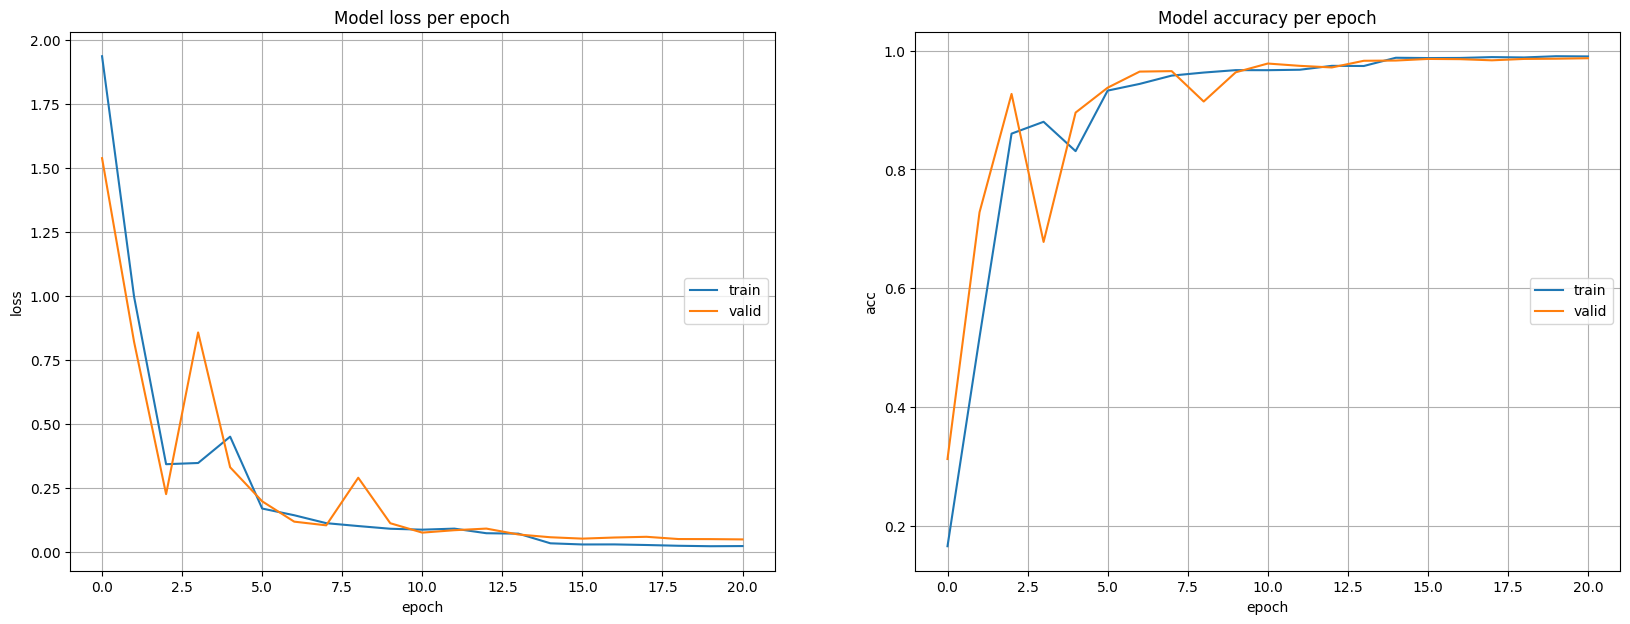

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,197,597 (176.23 MB)

 Trainable params: 15,214,089 (58.04 MB)

 Non-trainable params: 555,328 (2.12 MB)

 Optimizer params: 30,428,180 (116.07 MB)


 None

✅ Modèle entraîné en 1965 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 8 / 19
	• learning rate : 0.0001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9941 - loss: 0.0216
loss     = 0.0310820285230875
accuracy = 0.9914761781692505


In [ ]:
n_conv_layers_trainable = 8

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle
Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 72s 176ms/step - accuracy: 0.1647 - loss: 472.3806 - val_accuracy: 0.1341 - val_loss: 2.6923 - learning_rate: 0.0010
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 61s 161ms/step - accuracy: 0.1245 - loss: 1.9276 - val_accuracy: 0.1445 - val_loss: 2.2283 - learning_rate: 0.0010
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - accuracy: 0.1112 - loss: 6.5531 - val_accuracy: 0.0779 - val_loss: 2.3597 - learning_rate: 0.0010
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - accuracy: 0.1181 - loss: 2.0782 - val_accuracy: 0.1527 - val_loss: 5.2603 - learning_rate: 0.0010
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.1581 - loss: 2.2788
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
377/377 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step - accuracy: 0.1581 - loss: 2.2823 - val_accuracy: 0.0779 - val_loss: 15.1012 - learning_rate: 0.0010
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 61s 1

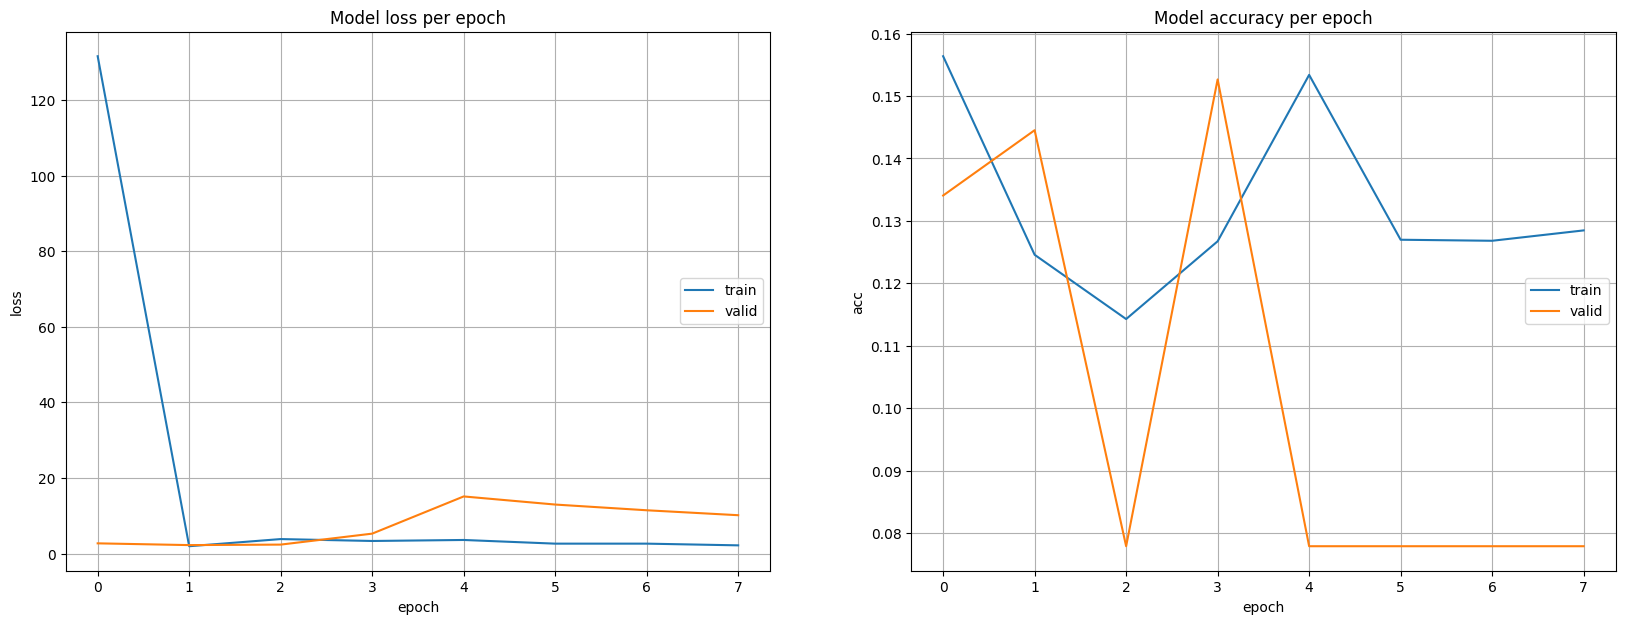

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,368,669 (153.99 MB)

 Trainable params: 7,088,137 (27.04 MB)

 Non-trainable params: 19,104,256 (72.88 MB)

 Optimizer params: 14,176,276 (54.08 MB)


 None

✅ Modèle entraîné en 483 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 10 / 190
	• learning rate : 0.001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:


/home/did/Windows/Mes documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.0478 - loss: 5.9851
loss     = 7.292651653289795
accuracy = 0.07787679135799408


In [ ]:
n_conv_layers_trainable = 10

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-3,  # LR baissé car bcp de couches à entraîner dès le début
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


###  Feature Extraction  
en sortie des couches 2 et 5 puis entraînement de différents modèles de classification (Arbre de décision, SVM, Random Forest et XGBoost)

In [ ]:
def DidFeatureExtractionClassification(
    X, Y, model, test_size=0.2, layers_output=2, xgb=False
):

    # extraction des features de la couche 2 et entraînement d'un modèle de classification
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import Model
    from tensorflow.keras.applications.vgg16 import preprocess_input

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    intermediate_layer_model = Model(
        inputs=model.input, outputs=model.layers[layers_output].output
    )
    print("Train feature extraction")
    X_train_features = intermediate_layer_model.predict(preprocess_input(X_train))
    print("Test feature extraction")
    X_test_features = intermediate_layer_model.predict(preprocess_input(X_test))

    # decision tree
    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier()
    clf.fit(X_train_features, Y_train)
    print(
        "score de classification avec Arbre de décision :",
        clf.score(X_test_features, Y_test),
    )

    # SVM
    from sklearn.svm import SVC

    clf = SVC()
    clf.fit(X_train_features, Y_train)
    print(
        "score de classification avec SVM               :",
        clf.score(X_test_features, Y_test),
    )

    # Random Forest
    from sklearn import ensemble

    clf = ensemble.RandomForestClassifier(n_jobs=-1)
    clf.fit(X_train_features, Y_train)
    print(
        "score de classification avec Random Forest     :",
        clf.score(X_test_features, Y_test),
    )

    # XGBoost (un peu long donc désactivée par défaut)
    if xgb == True:

        import xgboost as xgb

        clf = xgb.XGBClassifier()

        from sklearn import preprocessing

        le = preprocessing.LabelEncoder()
        le.fit(Y_train)
        Y_train_enc = le.transform(Y_train)
        Y_test_enc = le.transform(Y_test)

        clf.fit(X_train_features, Y_train_enc)
        print(
            "score de classification avec XGBoost           :",
            clf.score(X_test_features, Y_test_enc),
        )

    return X_train_features, X_test_features


In [ ]:
for i in [2, 5]:
    _, _ = DidFeatureExtractionClassification(
        X, Y, model_21_32, layers_output=i, xgb=True
    )


In [ ]:
for i in [2, 5]:
    _, _ = DidFeatureExtractionClassification(
        X, Y, model_12_64, layers_output=i, xgb=True
    )


In [ ]:
for i in [2, 5]:
    _, _ = DidFeatureExtractionClassification(
        X, Y, model_21_64, layers_output=i, xgb=True
    )


In [ ]:
DidSave(model_12_32, "/content/drive/MyDrive/BD/model_12_layers_32_batch")
for i in [2, 5]:
    _, _ = DidFeatureExtractionClassification(
        X, Y, model_12_32, layers_output=i, xgb=True
    )


Scores de référence des 4 modèles sur les données sans feature extraction

In [ ]:
# en utilisant les ensembles d’entraînement et de test standardisés et réduits à 2 dimensions

# decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
print("score de classification avec Arbre de décision :", clf.score(X_test, Y_test))

# SVM
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, Y_train)
print("score de classification avec SVM               :", clf.score(X_test, Y_test))

# Random Forest
from sklearn import ensemble

clf = ensemble.RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, Y_train)
print("score de classification avec Random Forest     :", clf.score(X_test, Y_test))

# XGBoost
import xgboost as xgb

clf = xgb.XGBClassifier()

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train_enc = le.transform(Y_train)
Y_test_enc = le.transform(Y_test)

clf.fit(X_train, Y_train_enc)
print("score de classification avec XGBoost           :", clf.score(X_test, Y_test_enc))


## ResNet50V2

In [ ]:
base_model = ResNet50V2(
    weights="imagenet", include_top=False
)  # par défaut input_shape = (224,224,3)

n_layers = len(base_model.layers)
conv_layers = [layer for layer in base_model.layers if "conv" in layer.name]
n_conv_layers = len(conv_layers)
print(
    f"{base_model.name} has {n_layers} layers in total, including {n_conv_layers} convolutional layers."
)

target_size = (224, 224)  # optimal pour ResNet


resnet50v2 has 190 layers in total, including 182 convolutional layers.


In [ ]:
batch_size = 32

train_generator, valid_generator, test_generator = DidDataGen(
    PATH_TRAIN,
    PATH_VALID,
    PATH_TEST,
    rn_v2_preprocess_input,
    target_size=target_size,
    batch_size=batch_size,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=359,
    horizontal_flip=True,
    vertical_flip=True,
)


Found 12042 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.


Entraînement du modèle


/home/did/Windows/Mes documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 122s 232ms/step - accuracy: 0.7938 - loss: 0.6289 - val_accuracy: 0.9430 - val_loss: 0.1929 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - accuracy: 0.9553 - loss: 0.1169 - val_accuracy: 0.9709 - val_loss: 0.1054 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - accuracy: 0.9643 - loss: 0.1000 - val_accuracy: 0.9783 - val_loss: 0.0643 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - accuracy: 0.9690 - loss: 0.0825 - val_accuracy: 0.9632 - val_loss: 0.1269 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - accuracy: 0.9703 - loss: 0.0803 - val_accuracy: 0.9771 - val_loss: 0.0671 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9783 - loss: 0.0589
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/s

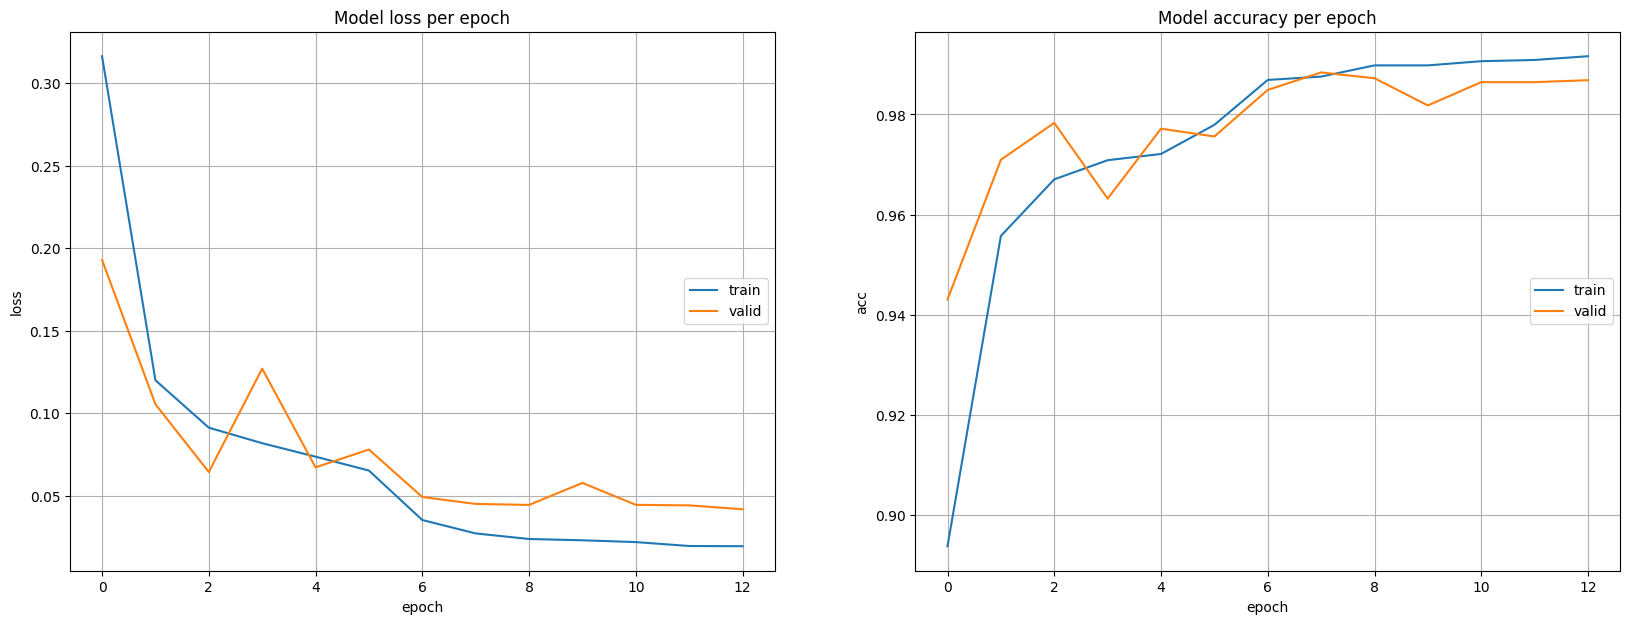

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,478,109 (299.37 MB)

 Trainable params: 26,142,857 (99.73 MB)

 Non-trainable params: 49,536 (193.50 KB)

 Optimizer params: 52,285,716 (199.45 MB)


 None

✅ Modèle entraîné en 883 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 0 / 190
	• learning rate : 0.0001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9935 - loss: 0.0228
loss     = 0.03148128092288971
accuracy = 0.9914761781692505


In [ ]:
n_conv_layers_trainable = 0

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle


/home/did/Windows/Mes documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 77s 174ms/step - accuracy: 0.8933 - loss: 0.3633 - val_accuracy: 0.9551 - val_loss: 0.1454 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9632 - loss: 0.0979 - val_accuracy: 0.9706 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9683 - loss: 0.0752 - val_accuracy: 0.9644 - val_loss: 0.1168 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.9709 - loss: 0.0769 - val_accuracy: 0.9733 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - accuracy: 0.9755 - loss: 0.0614 - val_accuracy: 0.9744 - val_loss: 0.0820 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.9747 - loss: 0.0659 - val_accuracy: 0.9744 - val_loss: 0.0826 - learning_rate: 1.0000e-04
Epoch 7/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 144

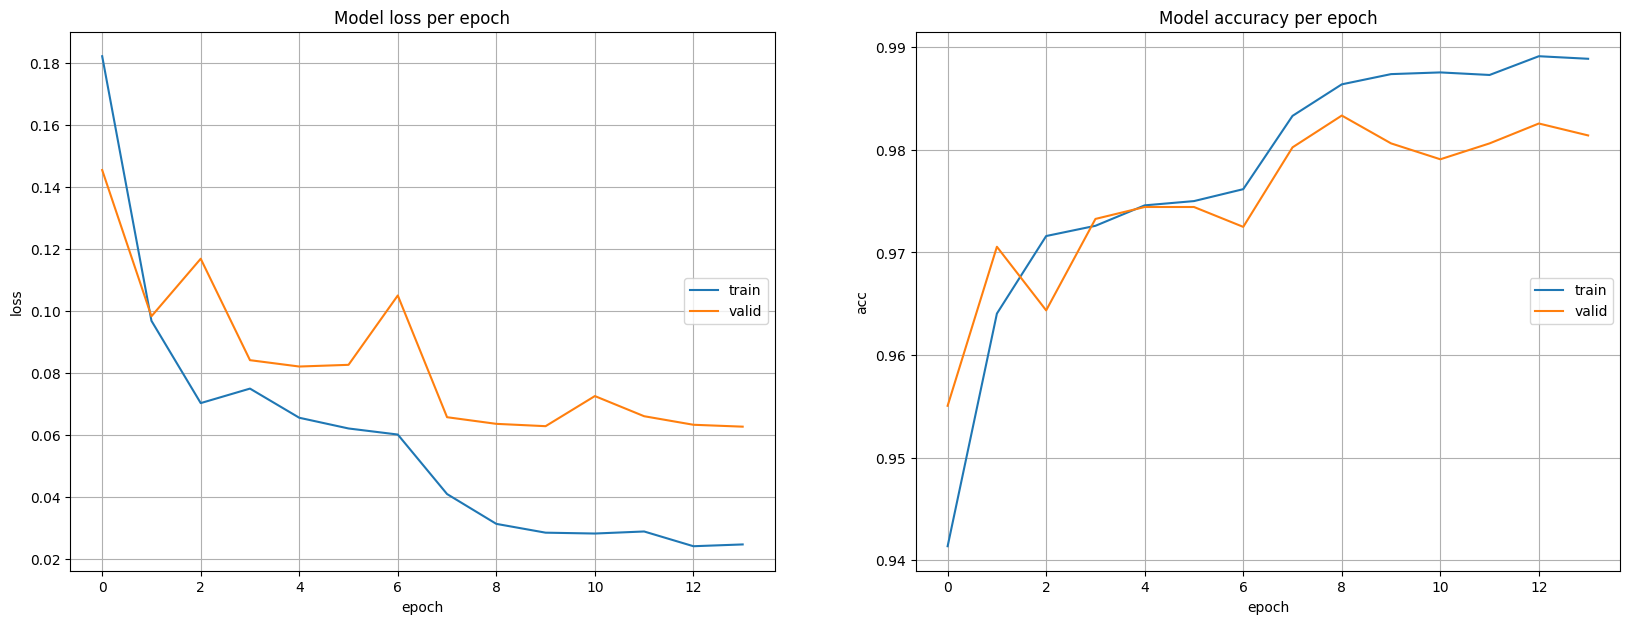

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,381,341 (253.22 MB)

 Trainable params: 20,094,473 (76.65 MB)

 Non-trainable params: 6,097,920 (23.26 MB)

 Optimizer params: 40,188,948 (153.31 MB)


 None

✅ Modèle entraîné en 847 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 60 / 190
	• learning rate : 0.0001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9892 - loss: 0.0344
loss     = 0.04858795553445816
accuracy = 0.984889566898346


In [ ]:
n_conv_layers_trainable = 60

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


In [ ]:
# on donne le chemin d'une image enregistrée sur pc
# et il ressort la classe prédite avec la probabilité
def test_from_local(chemin, model, test_generator):
    from tensorflow.keras.preprocessing import image
    import matplotlib.image as mpimg
    import numpy as np

    # met les images à la bonne dimension
    img = image.load_img(chemin, target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = rn_v2_preprocess_input(x)

    # obtenir l'indice de la classe la plus probable
    arg = int(tf.argmax(model.predict(x), axis=1).numpy())
    # obtenir la liste des noms des classes
    class_names = list(test_generator.class_indices.keys())
    # valeur de la probabilité que l'image appartienne à la classe
    proba = model.predict(x)[0][arg]

    return print(
        "Cette image a", proba * 100, "% de chance d'être un", class_names[arg]
    )


In [ ]:
# quelques tests de la fonction précédente (qui fonctionne bien)
test_from_local(
    "/content/drive/MyDrive/BD/a_tester_eosinophil.jpg", model2, test_generator
)


In [ ]:
# on donne le chemin d'une image enregistrée sur pc
# et il ressort la classe prédite avec la probabilité
def test_from_url(image_url, model, test_generator):
    from tensorflow.keras.preprocessing import image
    import matplotlib.image as mpimg
    import numpy as np
    import urllib.request
    import io

    with urllib.request.urlopen(image_url) as url:
        image_data = url.read()

    img = image.load_img(io.BytesIO(image_data), target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = rn_v2_preprocess_input(x)

    arg = int(tf.argmax(model.predict(x), axis=1).numpy())

    class_names = list(test_generator.class_indices.keys())
    proba = model.predict(x)[0][arg]

    return print(
        "Cette image a", proba * 100, "% de chance d'être un", class_names[arg]
    )


In [ ]:
# quelques tests de la fonction précédente (qui fonctionne bien)
test_from_url(
    "http://bioimage.free.fr/hem_image/hem_img/pb32l.jpg", model2, test_generator
)


## DenseNet121

In [ ]:
base_model = DenseNet121(
    weights="imagenet", include_top=False
)  # par défaut input_shape = (224,224,3)

n_layers = len(base_model.layers)
conv_layers = [layer for layer in base_model.layers if "conv" in layer.name]
n_conv_layers = len(conv_layers)
print(
    f"{base_model.name} has {n_layers} layers in total, including {n_conv_layers} convolutional layers."
)

target_size = (224, 224)  # optimal pour DenseNet


densenet121 has 427 layers in total, including 412 convolutional layers.


In [ ]:
batch_size = 32

train_generator, valid_generator, test_generator = DidDataGen(
    PATH_TRAIN,
    PATH_VALID,
    PATH_TEST,
    dn_preprocess_input,
    target_size=target_size,
    batch_size=batch_size,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=359,
    horizontal_flip=True,
    vertical_flip=True,
)


Found 12042 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.
Found 2581 images belonging to 9 classes.


Entraînement du modèle


/home/did/Windows/Mes documents/Librairies/blood-cells-classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 101s 205ms/step - accuracy: 0.9478 - loss: 0.1995 - val_accuracy: 0.9535 - val_loss: 0.1808 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - accuracy: 0.9799 - loss: 0.0618 - val_accuracy: 0.9644 - val_loss: 0.1715 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - accuracy: 0.9750 - loss: 0.0751 - val_accuracy: 0.9814 - val_loss: 0.0680 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - accuracy: 0.9646 - loss: 0.1831 - val_accuracy: 0.9771 - val_loss: 0.0736 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 64s 169ms/step - accuracy: 0.9825 - loss: 0.0477 - val_accuracy: 0.9810 - val_loss: 0.0647 - learning_rate: 1.0000e-04
Epoch 6/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9867 - loss: 0.0338
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━━━━━━━━━━━━━━━━ 65s 172ms/s

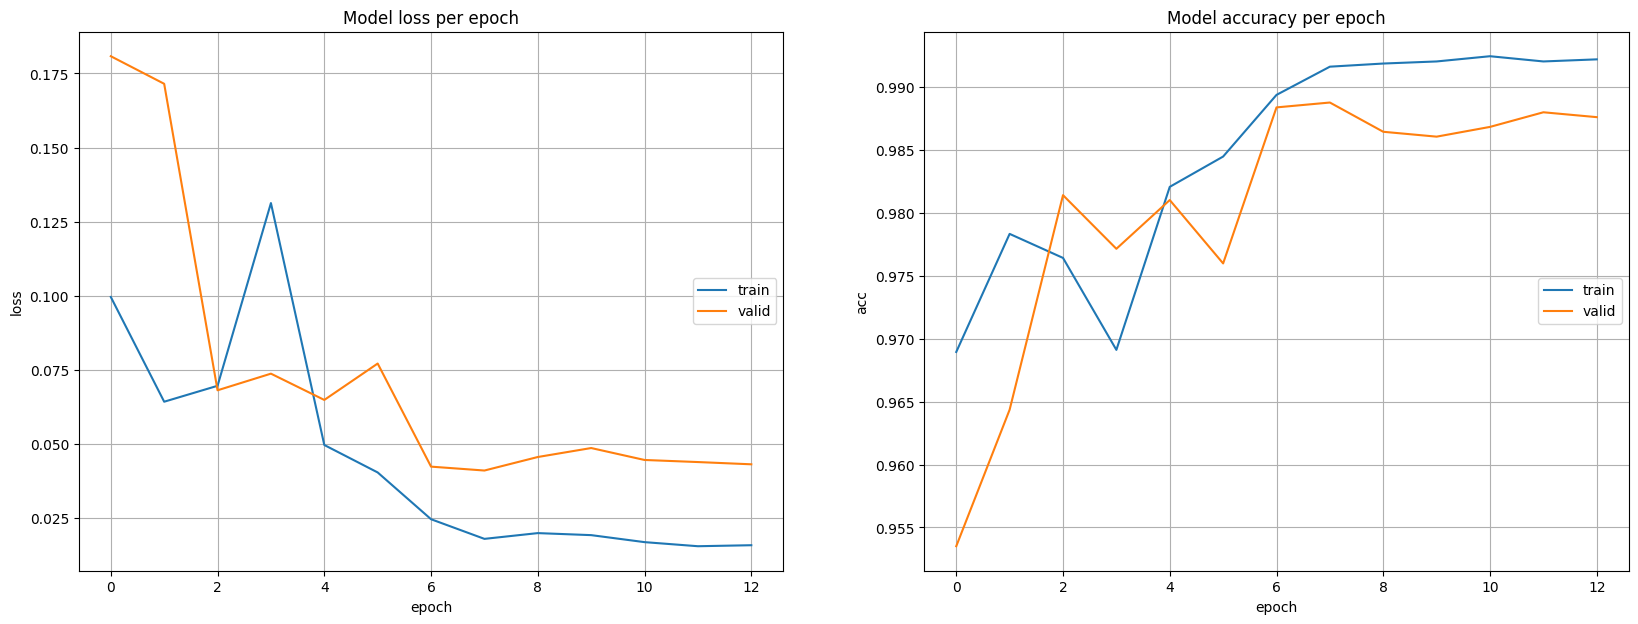

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,478,109 (299.37 MB)

 Trainable params: 26,142,857 (99.73 MB)

 Non-trainable params: 49,536 (193.50 KB)

 Optimizer params: 52,285,716 (199.45 MB)


 None

✅ Modèle entraîné en 872 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 0 / 190
	• learning rate : 0.0001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9934 - loss: 0.0278
loss     = 0.0364767462015152
accuracy = 0.9907012581825256


In [ ]:
n_conv_layers_trainable = 0

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


Entraînement du modèle
Epoch 1/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 87s 184ms/step - accuracy: 0.9573 - loss: 0.1700 - val_accuracy: 0.9822 - val_loss: 0.0662 - learning_rate: 1.0000e-04
Epoch 2/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.9826 - loss: 0.0467 - val_accuracy: 0.9698 - val_loss: 0.4343 - learning_rate: 1.0000e-04
Epoch 3/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.9796 - loss: 0.0570 - val_accuracy: 0.9826 - val_loss: 0.0645 - learning_rate: 1.0000e-04
Epoch 4/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9872 - loss: 0.0386
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
377/377 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.9872 - loss: 0.0386 - val_accuracy: 0.9810 - val_loss: 0.0797 - learning_rate: 1.0000e-04
Epoch 5/30
377/377 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9913 - loss: 0.0237 - val_accuracy: 0.9861 - val_loss: 0.0557 - learning_rate: 1.0000e-05
Epoch 6/30
377/377 ━━━━━━━━━━

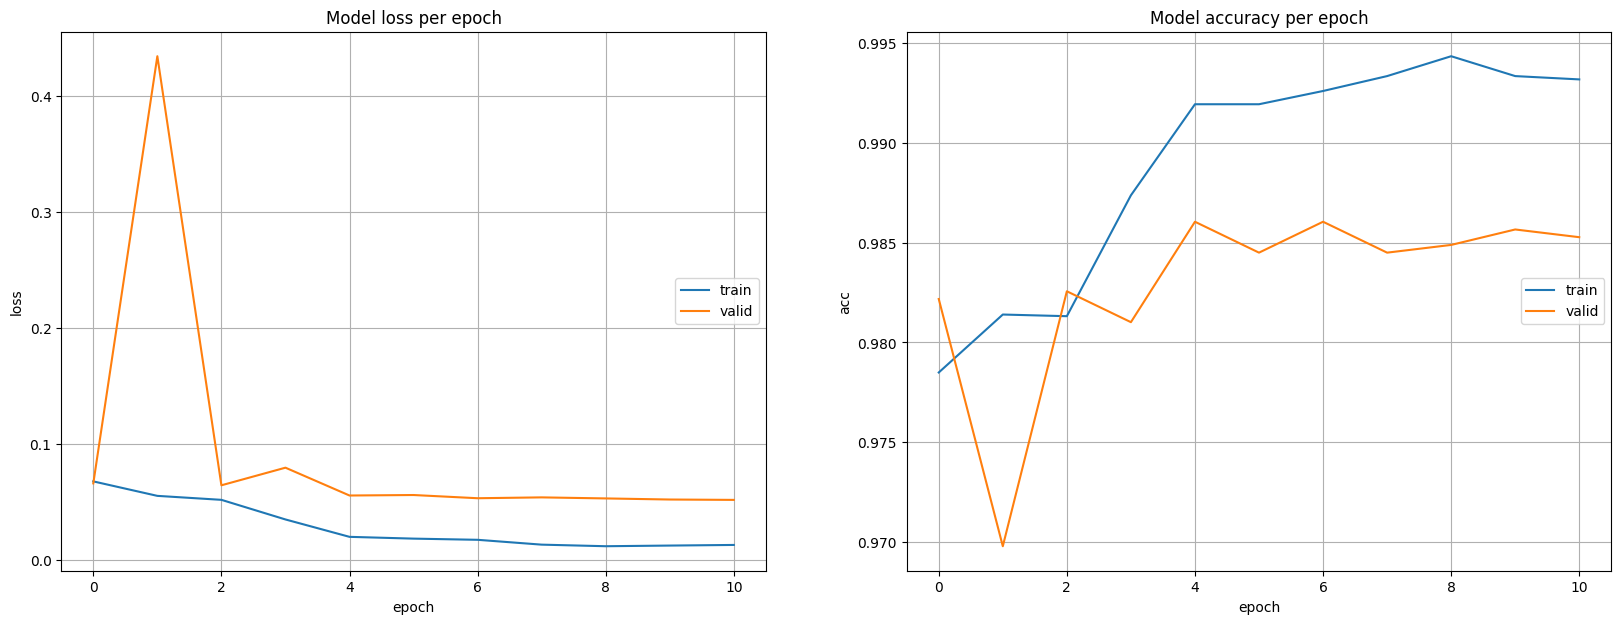

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,135,901 (294.25 MB)

 Trainable params: 25,471,753 (97.17 MB)

 Non-trainable params: 720,640 (2.75 MB)

 Optimizer params: 50,943,508 (194.33 MB)


 None

✅ Modèle entraîné en 680 s, avec les paramètres initiaux:
	• batch size des flows des image generators : 32
	• nb couches convolutionnelles entraînées   : 130 / 190
	• learning rate : 0.0001
	• epochs        : 30

Evaluation du modèle sur l'ensemble de test:
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9930 - loss: 0.0256
loss     = 0.032431453466415405
accuracy = 0.9910887479782104


In [ ]:
n_conv_layers_trainable = 130

model, history, score = fit_transfer_model(
    base_model,
    train_generator,
    valid_generator,
    test_generator,
    n_conv_layers_trainable=n_conv_layers_trainable,
    learning_rate=1e-4,
    nb_epochs=30,
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
path = os.path.join(
    PATH_KERAS,
    f"{base_model.name}_layers_{n_conv_layers_trainable}_batch_{batch_size}_{timestamp}",
)
model.save(path + ".keras")


In [ ]:
# Fonction permettant de préparer les données pour être conforme à l'entrée du DenseNet121

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(Y_dnet121)
saved_labels = encoder.inverse_transform([i for i in range(9)])


def preprocess_data(X, Y):

    X = np.float32(X)
    Y = np.array(Y)
    """
    function that pre-processes th dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    encoder = LabelEncoder()
    X = tf.keras.applications.densenet.preprocess_input(X)
    Y = encoder.fit_transform(Y)
    Y = tf.keras.utils.to_categorical(Y, 9)
    return X, Y


In [ ]:
from sklearn.model_selection import train_test_split

X_dnet121_train_base, X_dnet121_test_base, Y_dnet121_train_base, Y_dnet121_test_base = (
    train_test_split(X_dnet121, Y_dnet121, test_size=0.2)
)


In [ ]:
# Preprocessing train data pour le densenet121

X_dnet121_train, Y_dnet121_train = preprocess_data(
    X_dnet121_train_base, Y_dnet121_train_base
)


In [ ]:
# Preprocessing test data pour le densenet121

X_dnet121_test, Y_dnet121_test = preprocess_data(
    X_dnet121_test_base, Y_dnet121_test_base
)


In [ ]:
# Implémentation du DenseNet121

base_densenet121 = tf.keras.applications.DenseNet121(
    include_top=False, weights="imagenet"
)


In [ ]:
# Gel des 150 premières couches

for layer in base_densenet121.layers[:149]:
    layer.trainable = False
for layer in base_densenet121.layers[149:]:
    layer.trainable = True


In [ ]:
# Construction du modèle

model_densenet121 = tf.keras.models.Sequential()


In [ ]:
# Mise en forme des données pour le DenseNet121

model_densenet121.add(
    tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.resize_images(
            x, height_factor=1, width_factor=1, data_format="channels_last"
        )
    )
)


In [ ]:
# Construction du modèle (classifier)

kernel_init = "normal"

model_densenet121.add(base_densenet121)
model_densenet121.add(tf.keras.layers.Flatten())
model_densenet121.add(tf.keras.layers.BatchNormalization())
model_densenet121.add(
    tf.keras.layers.Dense(512, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121.add(tf.keras.layers.Dropout(0.7))
model_densenet121.add(tf.keras.layers.BatchNormalization())
model_densenet121.add(
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121.add(tf.keras.layers.Dropout(0.5))
model_densenet121.add(tf.keras.layers.BatchNormalization())
model_densenet121.add(
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121.add(tf.keras.layers.Dropout(0.3))
model_densenet121.add(
    tf.keras.layers.Dense(9, activation="softmax", kernel_initializer=kernel_init)
)


In [ ]:
# Callbacks

from tensorflow.keras import callbacks

CB = []

CB.append(
    callbacks.ModelCheckpoint(
        filepath="CB_best", monitor="val_accuracy", save_best_only=True
    )
)

CB.append(callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5))

CB.append(
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        min_delta=0.01,
        cooldown=4,
        verbose=1,
    )
)


In [ ]:
# Compile

optimizer = "Adam"

model_densenet121.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)


In [ ]:
# Train

history_densenet121 = model_densenet121.fit(
    x=X_dnet121_train,
    y=Y_dnet121_train,
    batch_size=32,
    epochs=30,
    callbacks=CB,
    validation_data=(X_dnet121_test, Y_dnet121_test),
    verbose=True,
)


In [ ]:
# Enregistrement du modèle

import pickle

pickle_out = open("/content/drive/MyDrive/BD/model_densenet121.pckl", "wb")
pickle.dump(model_densenet121, pickle_out)
pickle_out.close()


In [ ]:
# Enregistrement de l'historique

pickle_out = open("/content/drive/MyDrive/BD/history_densenet121.pckl", "wb")
pickle.dump(history_densenet121, pickle_out)
pickle_out.close()


In [ ]:
model_densenet121.summary()


In [ ]:
# Affichage de l'évolution de l'accuracy de la loss

train_acc = history_densenet121.history["accuracy"]

val_acc = history_densenet121.history["val_accuracy"]


In [ ]:
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="test accuracy")
plt.title("DenseNet121 : Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
train_loss = history_densenet121.history["loss"]

val_loss = history_densenet121.history["val_loss"]


In [ ]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="test loss")
plt.title("DenseNet121 : Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [ ]:
# Prédictions du modèle

probs_pred_densenet121 = model_densenet121.predict(X_dnet121_test)


In [ ]:
Y_pred_densenet121 = np.argmax(probs_pred_densenet121, axis=1)


In [ ]:
Y_test_densenet121_sparse = np.argmax(Y_dnet121_test, axis=1)


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_densenet121 = confusion_matrix(
    Y_test_densenet121_sparse, Y_pred_densenet121
)

print(conf_matrix_densenet121)


In [ ]:
from sklearn.metrics import classification_report

class_report_densenet121 = classification_report(
    Y_test_densenet121_sparse, Y_pred_densenet121
)

print(class_report_densenet121)


In [ ]:
# Implémentation du DenseNet121 sans geler aucun calque

base_densenet121_nf = tf.keras.applications.DenseNet121(
    include_top=False, weights="imagenet"
)


In [ ]:
model_densenet121_nf = tf.keras.models.Sequential()


In [ ]:
model_densenet121_nf.add(
    tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.resize_images(
            x, height_factor=1, width_factor=1, data_format="channels_last"
        )
    )
)


In [ ]:
# Construction du modèle (même classifier)

kernel_init = "normal"

model_densenet121_nf.add(base_densenet121_nf)
model_densenet121_nf.add(tf.keras.layers.Flatten())
model_densenet121_nf.add(tf.keras.layers.BatchNormalization())
model_densenet121_nf.add(
    tf.keras.layers.Dense(512, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121_nf.add(tf.keras.layers.Dropout(0.7))
model_densenet121_nf.add(tf.keras.layers.BatchNormalization())
model_densenet121_nf.add(
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121_nf.add(tf.keras.layers.Dropout(0.5))
model_densenet121_nf.add(tf.keras.layers.BatchNormalization())
model_densenet121_nf.add(
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer=kernel_init)
)
model_densenet121_nf.add(tf.keras.layers.Dropout(0.3))
model_densenet121_nf.add(
    tf.keras.layers.Dense(9, activation="softmax", kernel_initializer=kernel_init)
)


In [ ]:
# Compile

optimizer = "Adam"

model_densenet121_nf.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)


In [ ]:
# Train

history_densenet121_nf = model_densenet121_nf.fit(
    x=X_dnet121_train,
    y=Y_dnet121_train,
    batch_size=32,
    epochs=30,
    callbacks=CB,
    validation_data=(X_dnet121_test, Y_dnet121_test),
    verbose=True,
)


In [ ]:
# Enregistrement du modèle et de l'historique

import pickle

pickle_out = open("/content/drive/MyDrive/BD/model_densenet121_nf.pckl", "wb")
pickle.dump(model_densenet121_nf, pickle_out)
pickle_out.close()


In [ ]:
pickle_in = open("/content/drive/MyDrive/BD/model_densenet121_nf.pckl", "rb")
model_densenet121_nf = pickle.load(pickle_in)


In [ ]:
pickle_out = open("/content/drive/MyDrive/BD/history_densenet121_nf.pckl", "wb")
pickle.dump(history_densenet121_nf, pickle_out)
pickle_out.close()


In [ ]:
model_densenet121_nf.summary()


In [ ]:
# Courbes accuracy et loss

train_acc_nf = history_densenet121_nf.history["accuracy"]

val_acc_nf = history_densenet121_nf.history["val_accuracy"]


In [ ]:
plt.plot(train_acc_nf, label="train accuracy")
plt.plot(val_acc_nf, label="test accuracy")
plt.title("DenseNet121 : Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
train_loss_nf = history_densenet121_nf.history["loss"]

val_loss_nf = history_densenet121_nf.history["val_loss"]


In [ ]:
plt.plot(train_loss_nf, label="train loss")
plt.plot(val_loss_nf, label="test loss")
plt.title("DenseNet121 : Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [ ]:
# Prédictions du modèle

probs_pred_densenet121_nf = model_densenet121_nf.predict(X_dnet121_test)


In [ ]:
Y_pred_densenet121_nf = np.argmax(probs_pred_densenet121_nf, axis=1)


In [ ]:
Y_test_densenet121_sparse = np.argmax(Y_dnet121_test, axis=1)


In [ ]:
# Matrice de confusion et rapports de classification

from sklearn.metrics import confusion_matrix

conf_matrix_densenet121_nf = confusion_matrix(
    Y_test_densenet121_sparse, Y_pred_densenet121_nf
)

print(conf_matrix_densenet121_nf)


In [ ]:
from sklearn.metrics import classification_report

class_report_densenet121_nf = classification_report(
    Y_test_densenet121_sparse, Y_pred_densenet121_nf
)

print(class_report_densenet121_nf)


In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(
    classification_report_imbalanced(Y_test_densenet121_sparse, Y_pred_densenet121_nf)
)


In [ ]:
# Génération et classification d'images du test set


plt.figure(figsize=(10, 6))

for i in range(8):

    k = random.randint(0, len(X_dnet121_test_base))
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_dnet121_test_base[k])
    plt.axis(False)
    plt.title(
        saved_labels[Y_test_densenet121_sparse[k]]
        + "\npredicted as\n"
        + saved_labels[Y_pred_densenet121_nf[k]]
    )
plt.show()


# Conclusion

La segmentation n’a pas permis d'améliorer les scores de classification mais les scores de précision obtenus avec différents modèles de machine learning (avec et sans oversampling) et de deep learning (avec et sans data generation) sur les cellules saines sont très satisfaisants :
*   Machine Learning : 91% avec le classifier XGBoost
*   Deep Learning : 95 à 98% avec les CNN VGG16, ResNet50 et DenseNet121
*   Feature Extraction : 98 à 99% avec VGG16 puis XGBoost

Différentes pistes d’amélioration des scores des modèles testées pourraient être testées :
*   Machine Learning : le score obtenu par classifier XGBoost pourrait être amélioré par l’entraînement sur les données rééchantillonnées par Over Sampling.
*   Transfer Learning : les scores obtenus par les réseaux neuronaux convolutifs profonds tels que ResNet50 et DenseNet121 pourraient être optimisés par la génération d’images ainsi que la classification par un modèle de machine learning après l’extraction des features.
*   Feature Extraction : les scores obtenus après entraînement de classifiers sur les features extraites en sortie des couches intermédiaires du VGG16 pourraient être optimisés par un réglage des hyperparamètres des modèles de machine learning utilisés.

Pour atteindre l’objectif final du diagnostic certaines pathologies par identification des cellules sanguines anormales, il conviendrait d’entraîner ces modèles sur les jeux de données incluant des cellules anormales et distinguer ainsi les cellules pathologiques après avoir identifié leur type.